# **A quick introduction to `tess_cpm`** 
In this notebook we'll go through two examples of how to use `tess_cpm` python library to extract "de-trended" FFI light curves.\
The library is still a work in progress so apologies for the inevitable bugs!

The second example will be a supernova light curve (ASASSN-18tb) and might be relevant for those of you interested in **sources with long-term variability**. 

## **Causal Pixel Model (CPM)**
I'll skip the details of how CPM works, but if you're interested you should take a look at the original papers ([Wang et al. 2016](https://ui.adsabs.harvard.edu/abs/2016PASP..128i4503W/abstract), [Wang et al. 2017](https://ui.adsabs.harvard.edu/abs/2017arXiv171002428W/abstract), and [Schölkopf et al. 2016](https://www.pnas.org/content/113/27/7391) for a more theoretical explanation).

The core assumption behind CPM is that **common light curve variations across distant pixels are likely to be systematic effects**. This assumption is based on the idea that while we would **not** expect multiple distant stars to simultaneously show the same variation, *TESS* systematics (e.g., spacecraft jitter, scattered light) **would** simultaneously affect multiple distant pixels.\
Therefore, variations in a single pixel's light curve that can be modeled as a linear combination of many other *distant* pixels' light curves are probably systematic effects. CPM tries to capture these common variations in a single pixel so that it can be subtracted from the original pixel flux measurements to provide a "de-trended" pixel light curve.

## **Example 1 (TIC 395130640)**
Let's start off by downloading a TESS FFI cutout using TESScut ([Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)).\
*TESS-CPM* requires a reasonably large cutout since CPM works by using many other distant pixels as the model's features (i.e., regressors, predictors).\
We've recently been using 100x100 pixel cutouts, but the smallest cutout we've used was a 32x32 pixel cutout. One thing to keep in mind is that these FFI cutouts take up quite a bit of space (${\sim} 250~\mathrm{MB}$ for a 100x100 pixel cutout from one sector) and can also take a while to download.\
With that in mind, for this example I'll download a 50x50 pixel cutout of TIC 395130640.

In [1]:
from astroquery.mast import Tesscut
from astroquery.mast.utils import parse_input_location
import os
import lightkurve as lk

search_result = lk.search_tesscut(target="TIC395130640", sector=[11, 12])
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,TESScut,1426,TIC395130640,0.0
1,TESS Sector 12,2019,TESScut,1426,TIC395130640,0.0


In [2]:
tpf_collection = search_result.download_all(cutout_size=50)
tpf_collection

TargetPixelFileCollection of 2 objects:
    0: TessTargetPixelFile(TICID: TIC395130640)
    1: TessTargetPixelFile(TICID: TIC395130640)

Let's take a look at the observations from Sector 11.
The current main interface to the `tess_cpm` package is through the `Source` class.  
We'll initialize an instance of the `Source` class by passing the path to the FFI cutouts.  
The `remove_bad` keyword argument specifies whether we want to remove the data points that have been flagged by the TESS QUALITY array. 

In [7]:
import matplotlib.pyplot as plt
import tess_cpm
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["figure.dpi"] = 300

s = tess_cpm.Source(tpf_collection[0].path, remove_bad=True)

Removing 68 bad data points (out of 1248) using the TESS provided QUALITY array


We can see the median flux image of the FFI cutouts using the `plot_cutout()` method.\
It's usually a good idea to check the image to ensure you're not around the edges of the FFIs.\
The `l` and `h` keyword arguments set the lower and upper limits (as a percentage) of the range of fluxes to plot. 

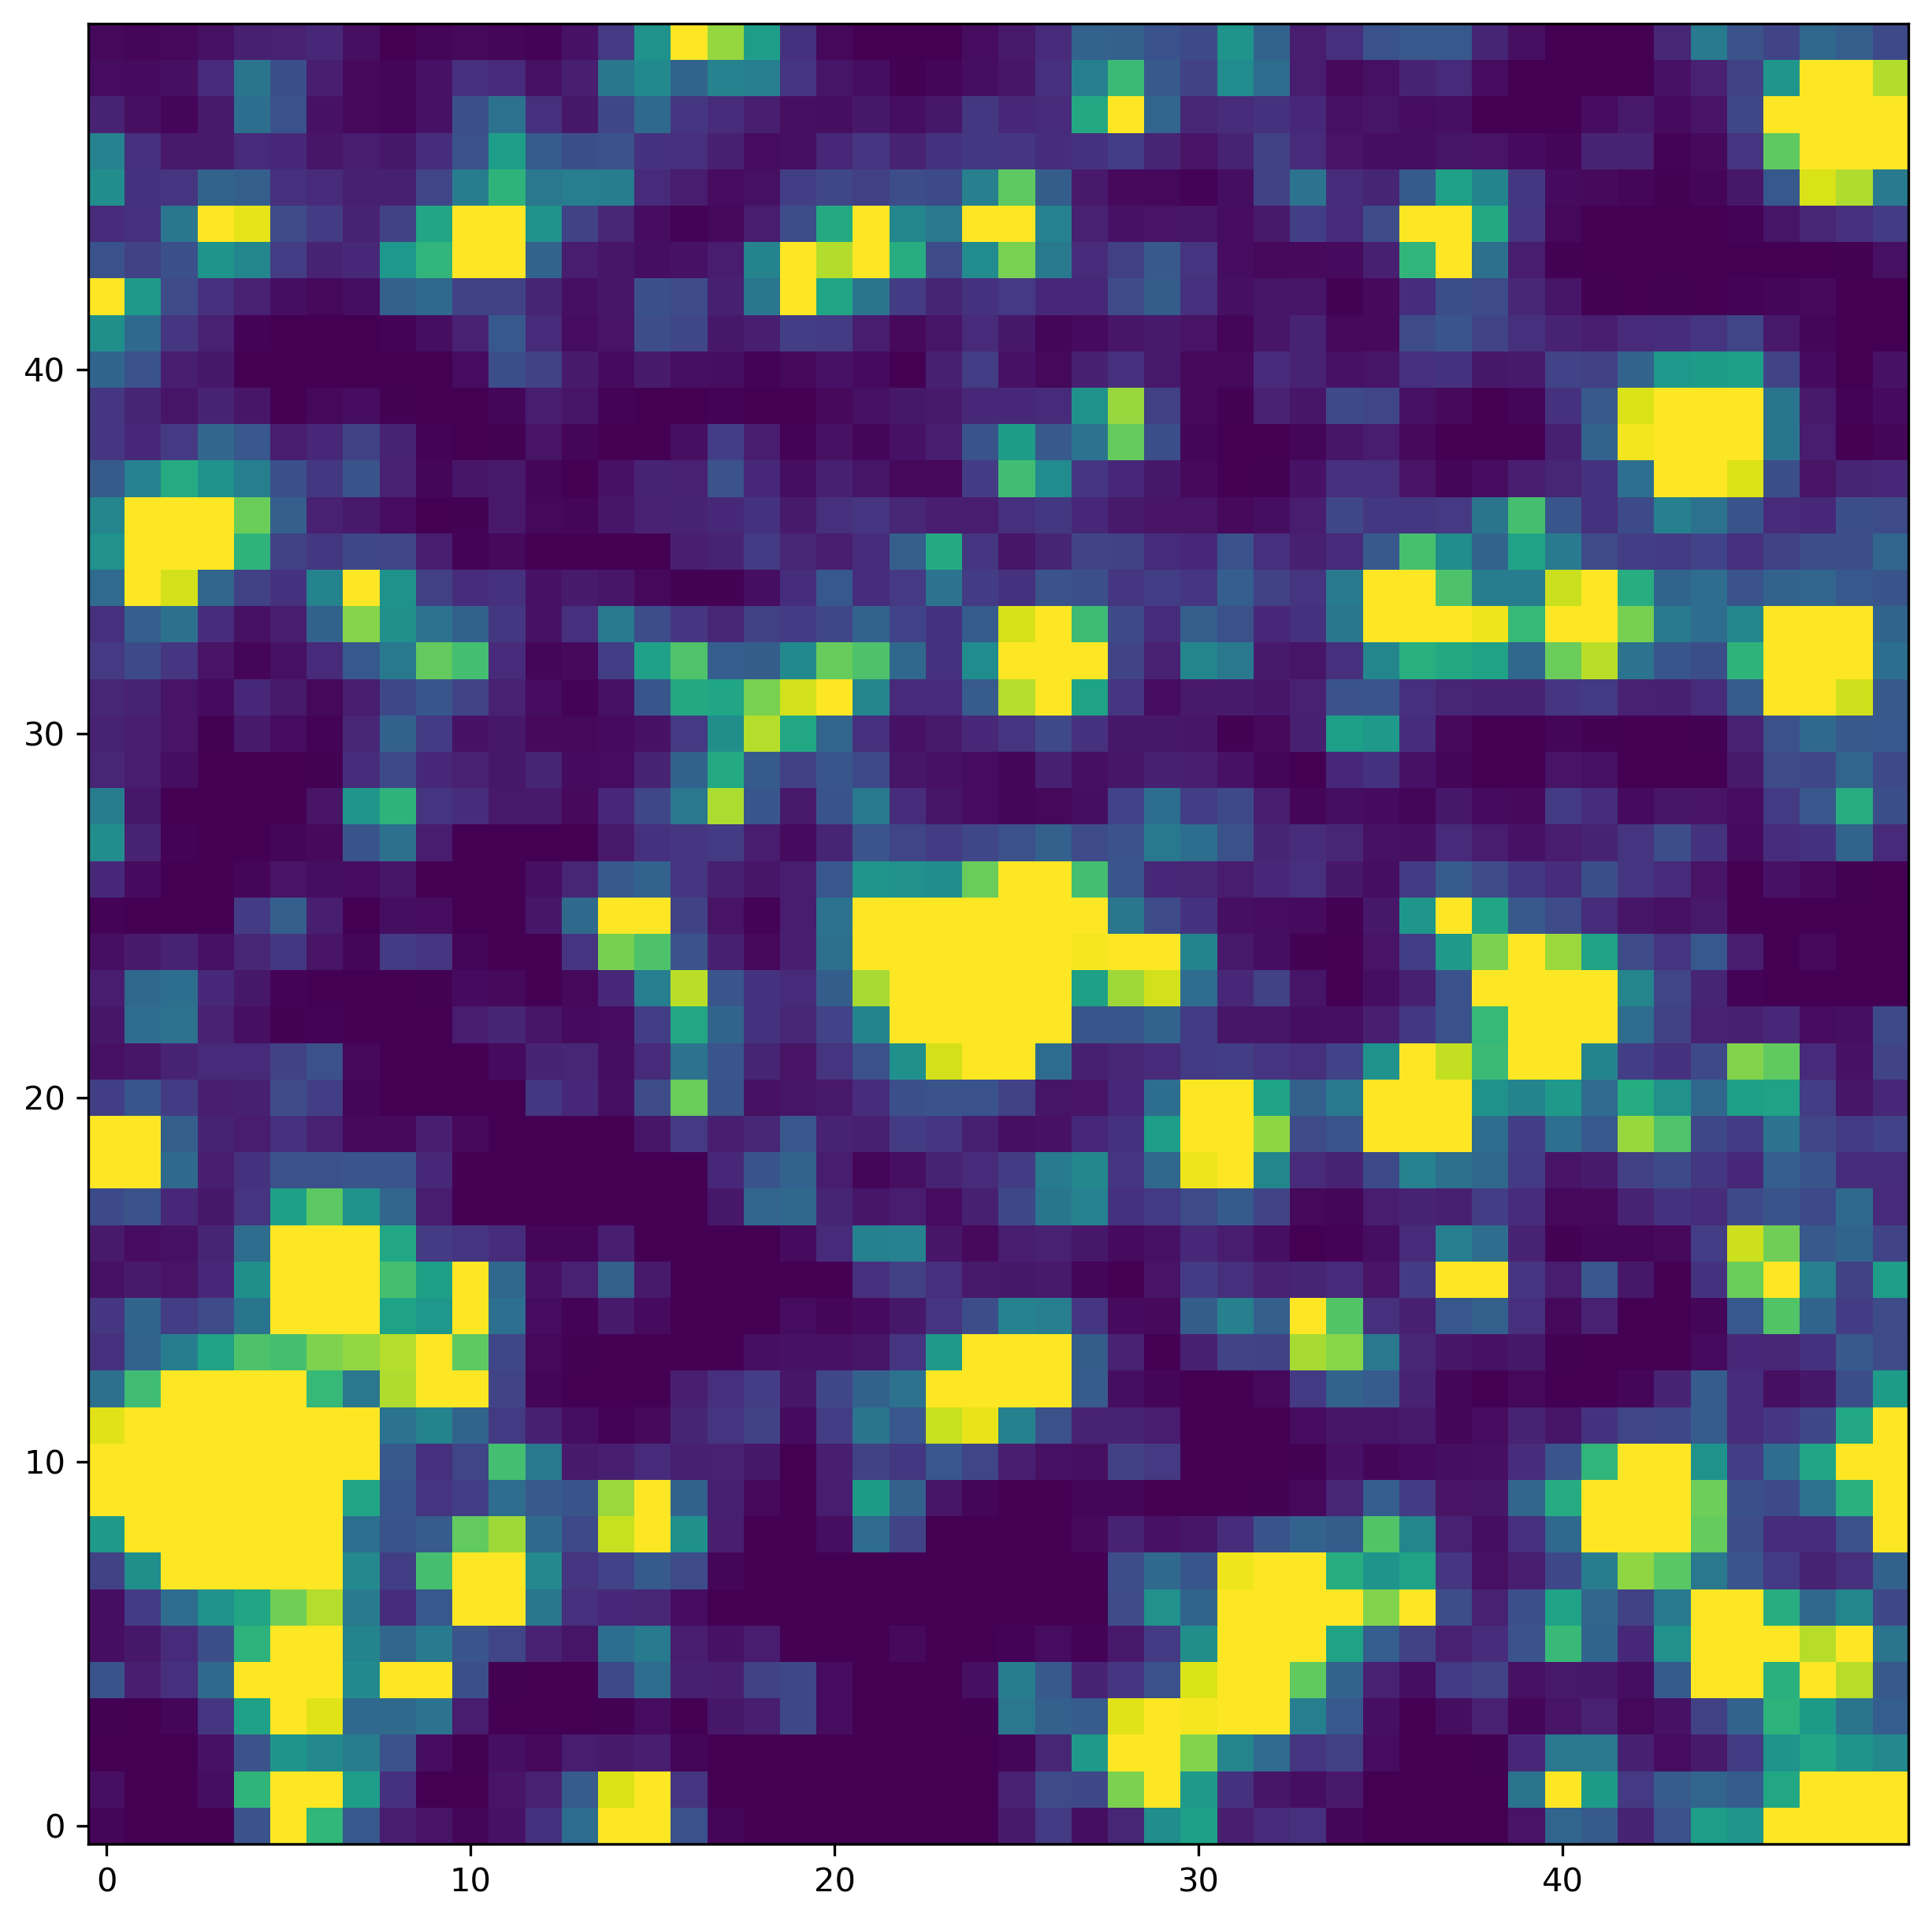

In [9]:
_ = s.plot_cutout(l=10, h=90)

The next thing to do is specify the set of pixels (i.e., the aperture) we believe the source falls on.\
The source will roughly be at the center of the image if the cutouts were obtained by providing the source coordinates or the TIC to TESScut.
  
We can specify the set of pixels by using the `set_aperture()` method.  
The current code only allows for a rectangular aperture. We're planning to allow the user to specify any aperture in the near future (end of September 2020).  
We can define the extent of the rectangular aperture in the `set_aperture()` method using the `rowlims` and `collims` argument. For each of these arguments, just pass a list that specifies the lower and upper limits of the aperture. For example `rowlims=[50, 52]` means rows 50, 51, and 52 are in the aperture.  

After specifying the aperture, we can visually check to see that your aperture is actually covering the pixels we're interested in using `plot_cutout()` again.  
We can see our aperture by setting `show_aperture=True`. The overlayed aperture will make the pixels in the aperture look white. 
We can also pass the region of the cutour we'd like to see (instead of the entire cutout) by specifying the rows and columns in the same way we defined the aperture.

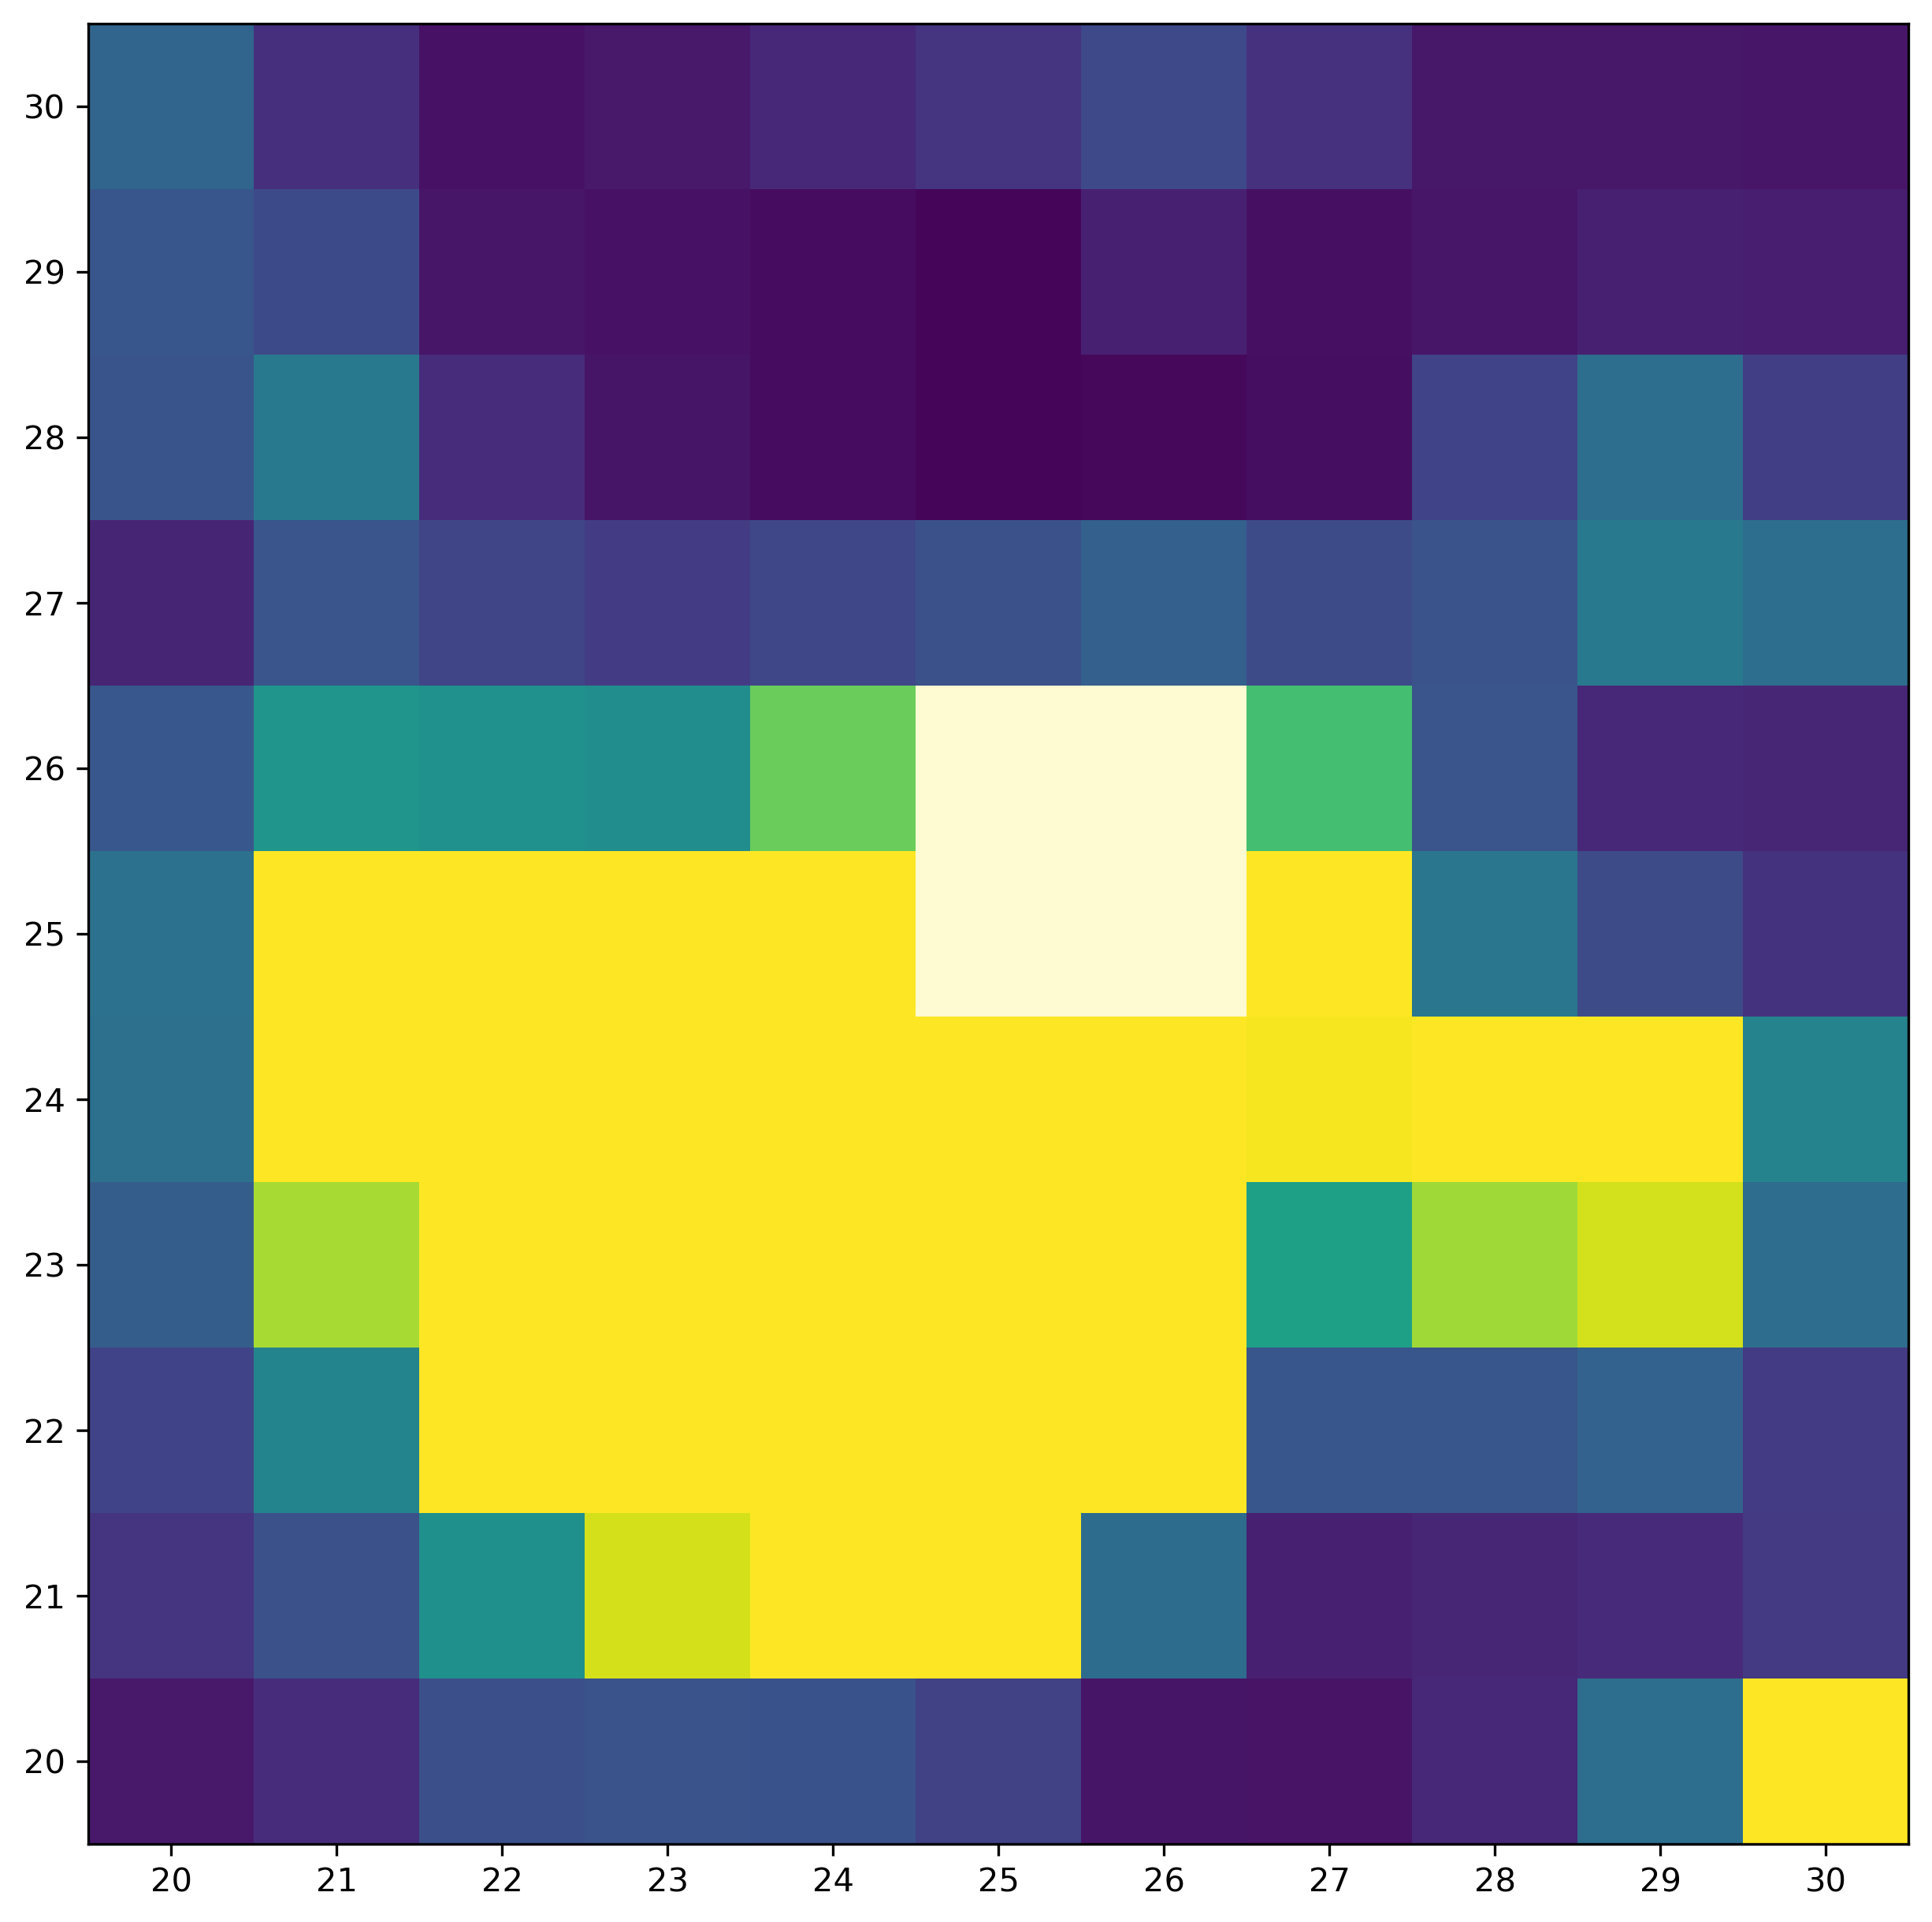

In [11]:
s.set_aperture(rowlims=[25, 26], collims=[25, 26])
# s.set_aperture(rowlims=[23, 26], collims=[23, 26])

s.plot_cutout(rowlims=[20, 30], collims=[20, 30], show_aperture=True, l=10, h=90);

After specifying the aperture, we can check each pixel's light curves using the `plot_pix_by_pix()` method.  

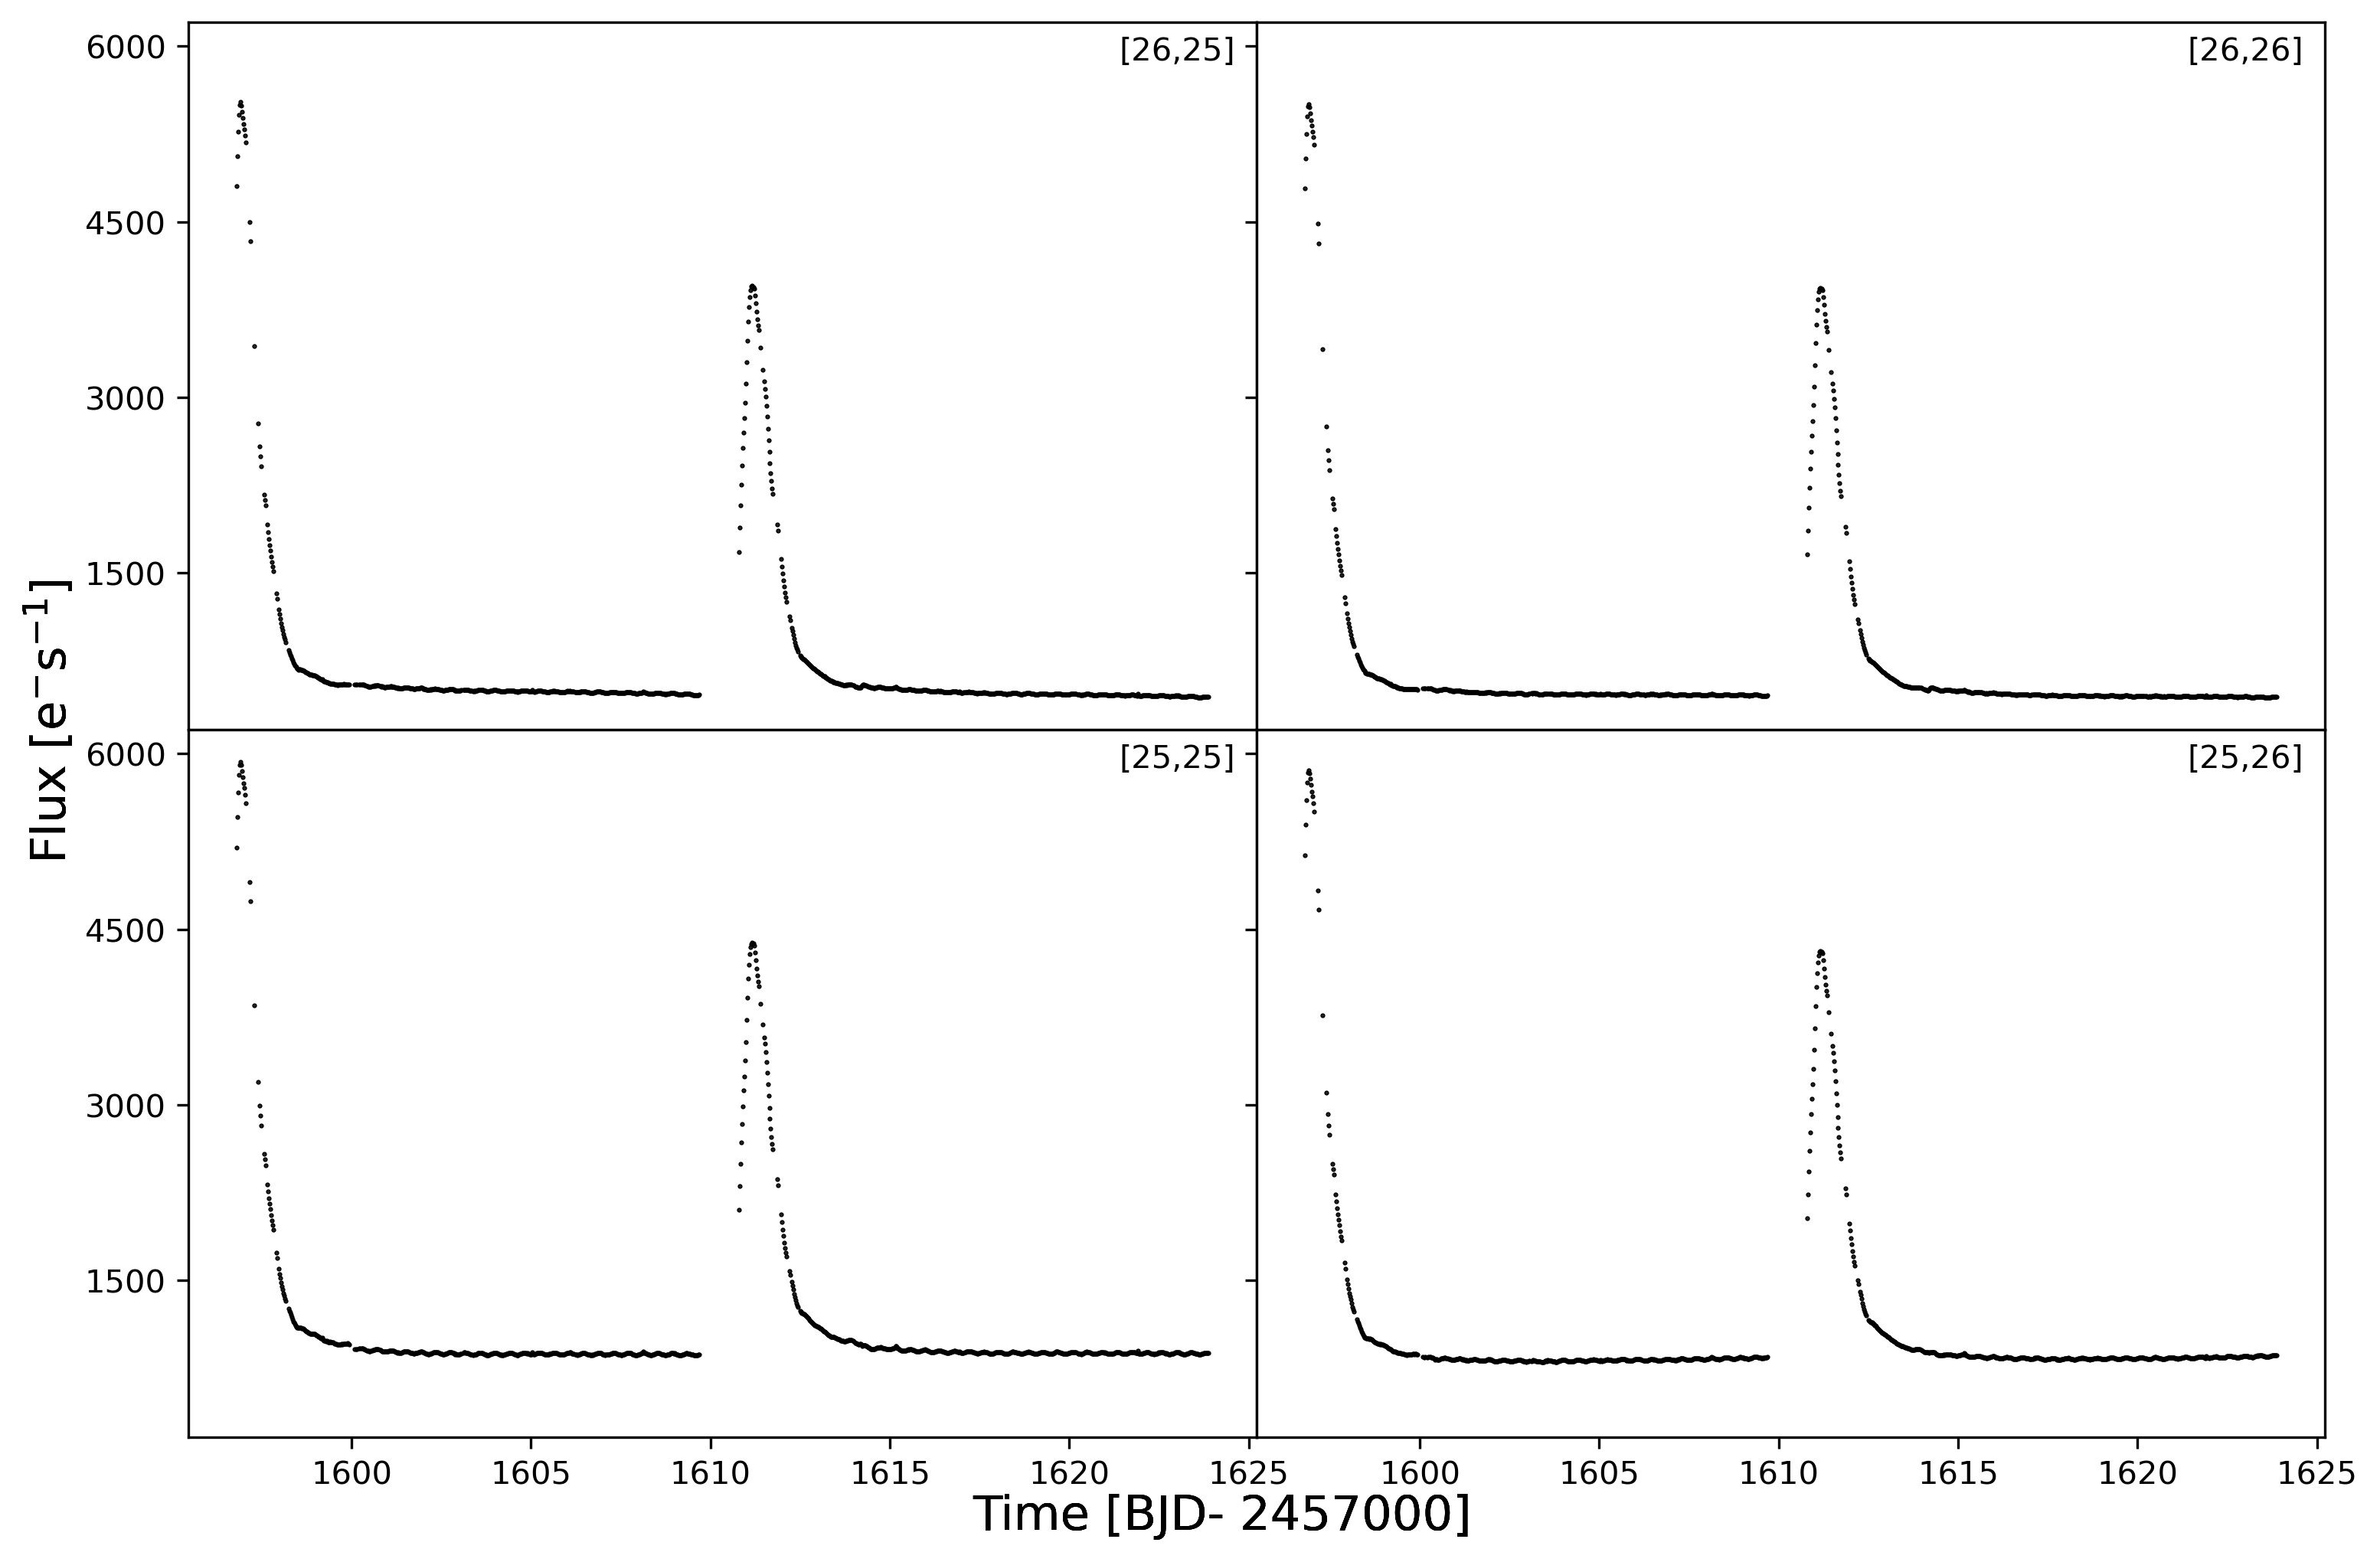

In [13]:
_ = s.plot_pix_by_pix()  # Calling the method without any arguments plots the raw flux

The current CPM implementation works with all pixels' fluxes normalized such that they are zero-centered & median-divided.

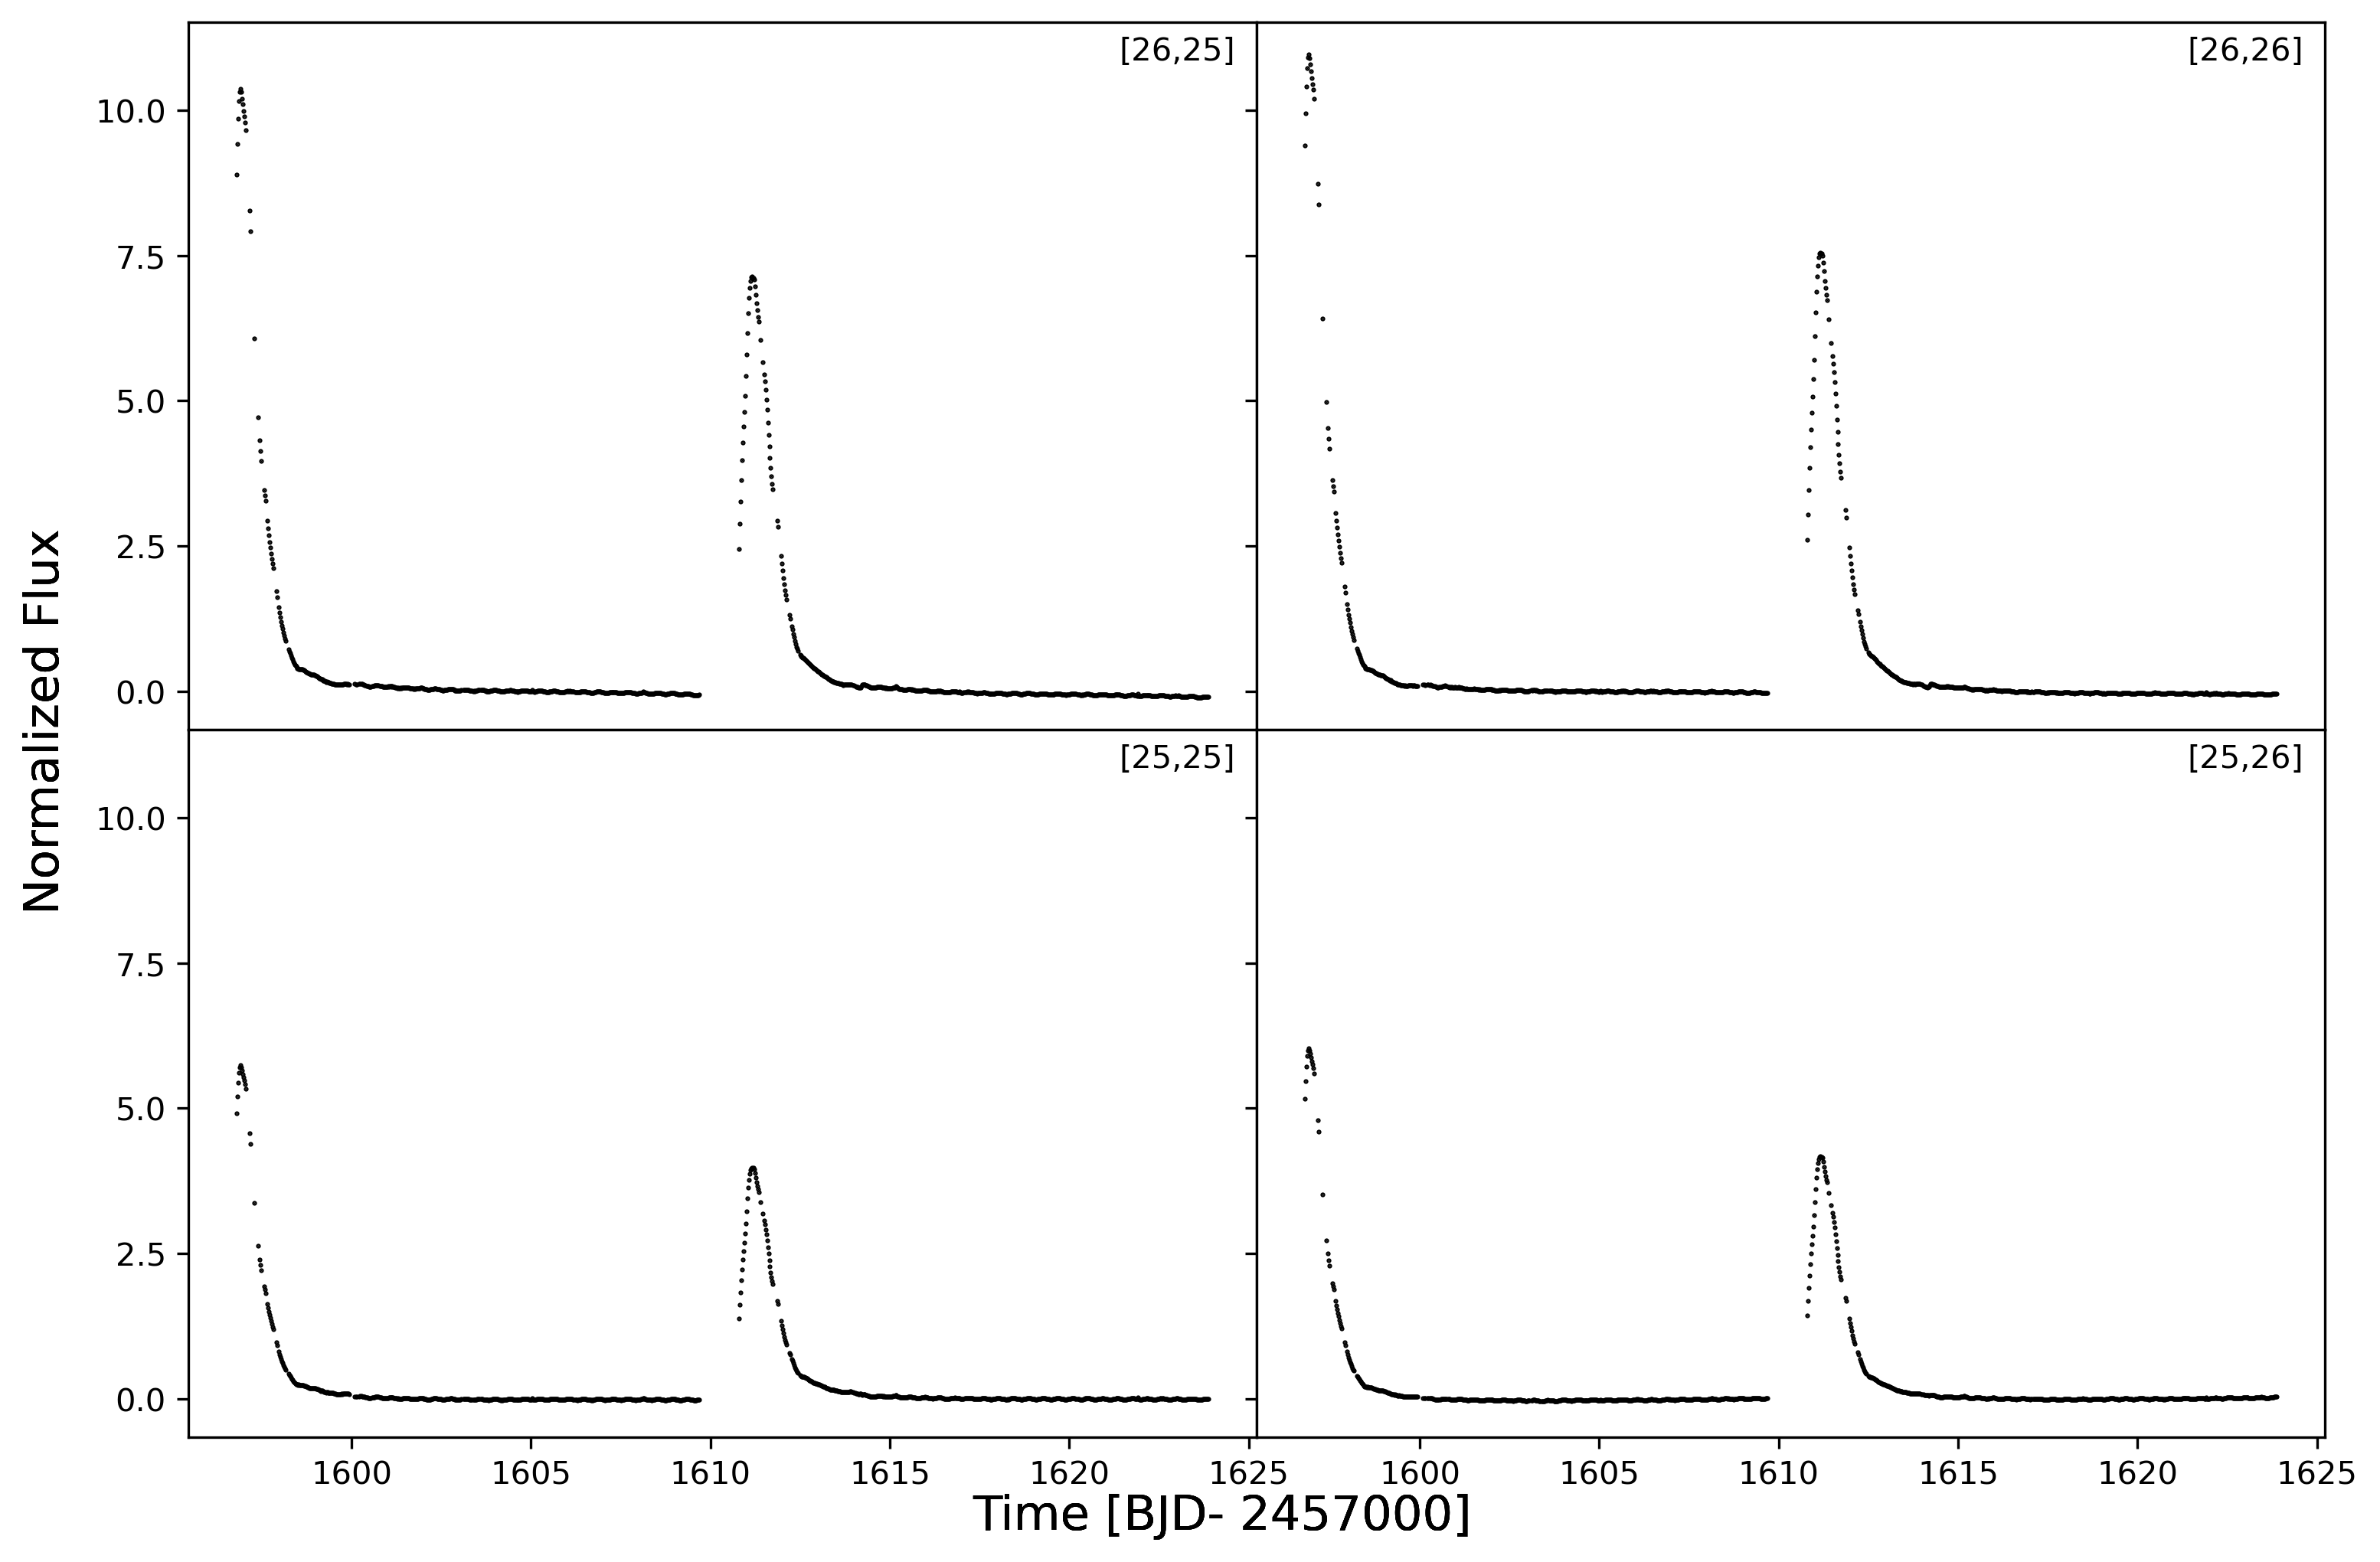

In [15]:
_ = s.plot_pix_by_pix(data_type="normalized_flux")  # Setting `data_type=normalized_flux` will plot the zero-centered & median-divided flux.

Let's specify our model.\
As mentioned at the beginning of this notebook, CPM's main idea is to model a single pixel's light curve as a linear combination of a bunch of other pixels' light curves.\
Since our FFI cutout isn't that large (50x50 pixels), let's model a single pixel as a combination of 64 pixel light curves. 

In [17]:
s.add_cpm_model(exclusion_size=5, n=64, predictor_method="similar_brightness")

We can check our above choices using the `plot_model()` method.\
In the plot belowe, the single white pixel is the target pixel (that we are trying to model), the shaded red area surrounding the target pixel is the *exclusion region* where predictor pixels are *not* allowed to be chosen from (since they may be pixels from the same source), and the other pixels in red are the chosen predictor pixels.

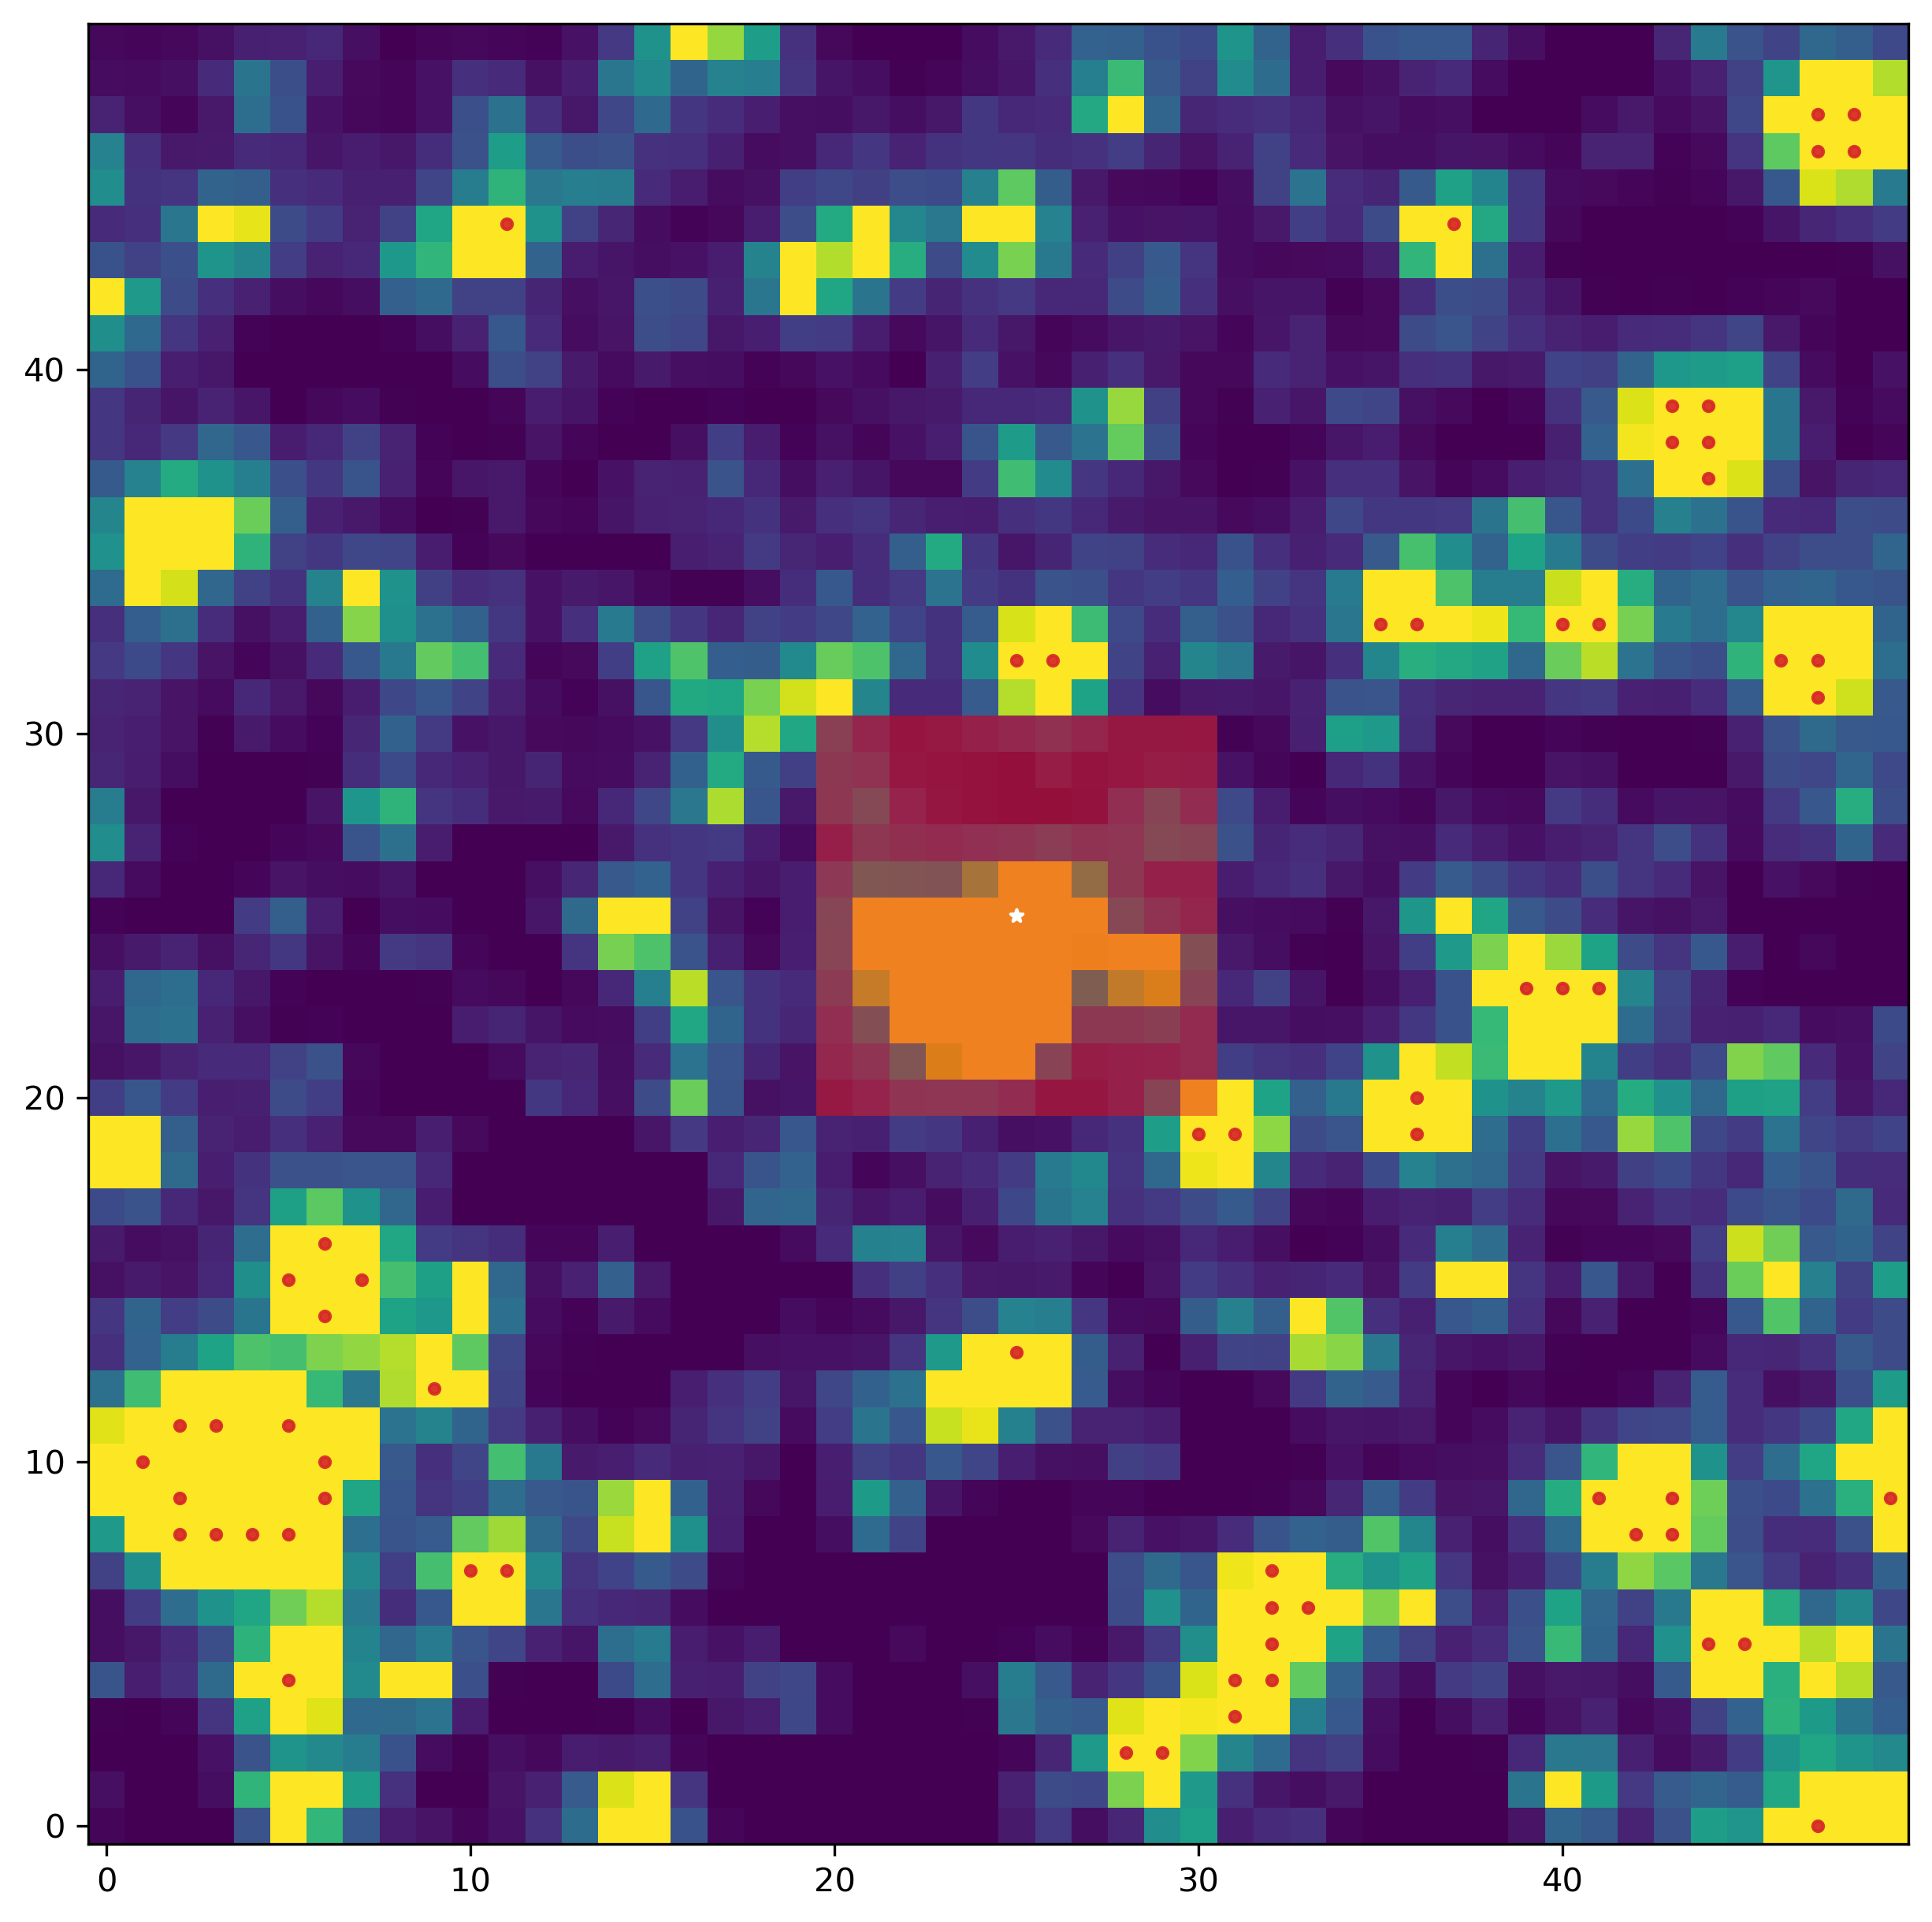

In [19]:
_ = s.models[0][0].plot_model(size_predictors=10)  # This method allows us to see our above choices

Given that we're using 64 light curves to model a single light curve our model is very prone to overfit in its current form.  
One of the ways of preventing overfitting is to constrain the flexibility of the model through regularization.  
Currently we use L2 (Ridge) regularization. L2 regularization is equivalent to placing a Gaussian prior on each of the coefficients (see $\S 2.1$ of [Luger et al. 2017](https://ui.adsabs.harvard.edu/abs/2018AJ....156...99L/abstract)).\ 
We set the L2 regularization value using `set_regs()`. In the current implementation the value is the reciprocal of the prior variance (i.e., precision) on the coefficients.\
*Small values mean weak regularization and large values mean strong regularization*. 

In [21]:
# While we 'should' be using cross-validation to set the regularization value, for this example we'll just use `0.1`.
s.set_regs([0.1])  # The regularization value(s) need to be passed as a list 

We can now perform least squares regression to model the target pixel's light curve with the `holdout_fit_predict()` method.
In addition to regularization, we also use a train-and-test framework to prevent overfitting. In this framework we split the lightcurve into **k** contiguous sections and predict the **i-th** section with the coefficients obtained from training on all the other sections.

In [23]:
# s.holdout_fit_predict(k=5);
s.holdout_fit_predict(k=100);

Let's plot the CPM-subtracted flux for each pixel. Specifying `split=True` will plot each of the **k** sections in different colors. 

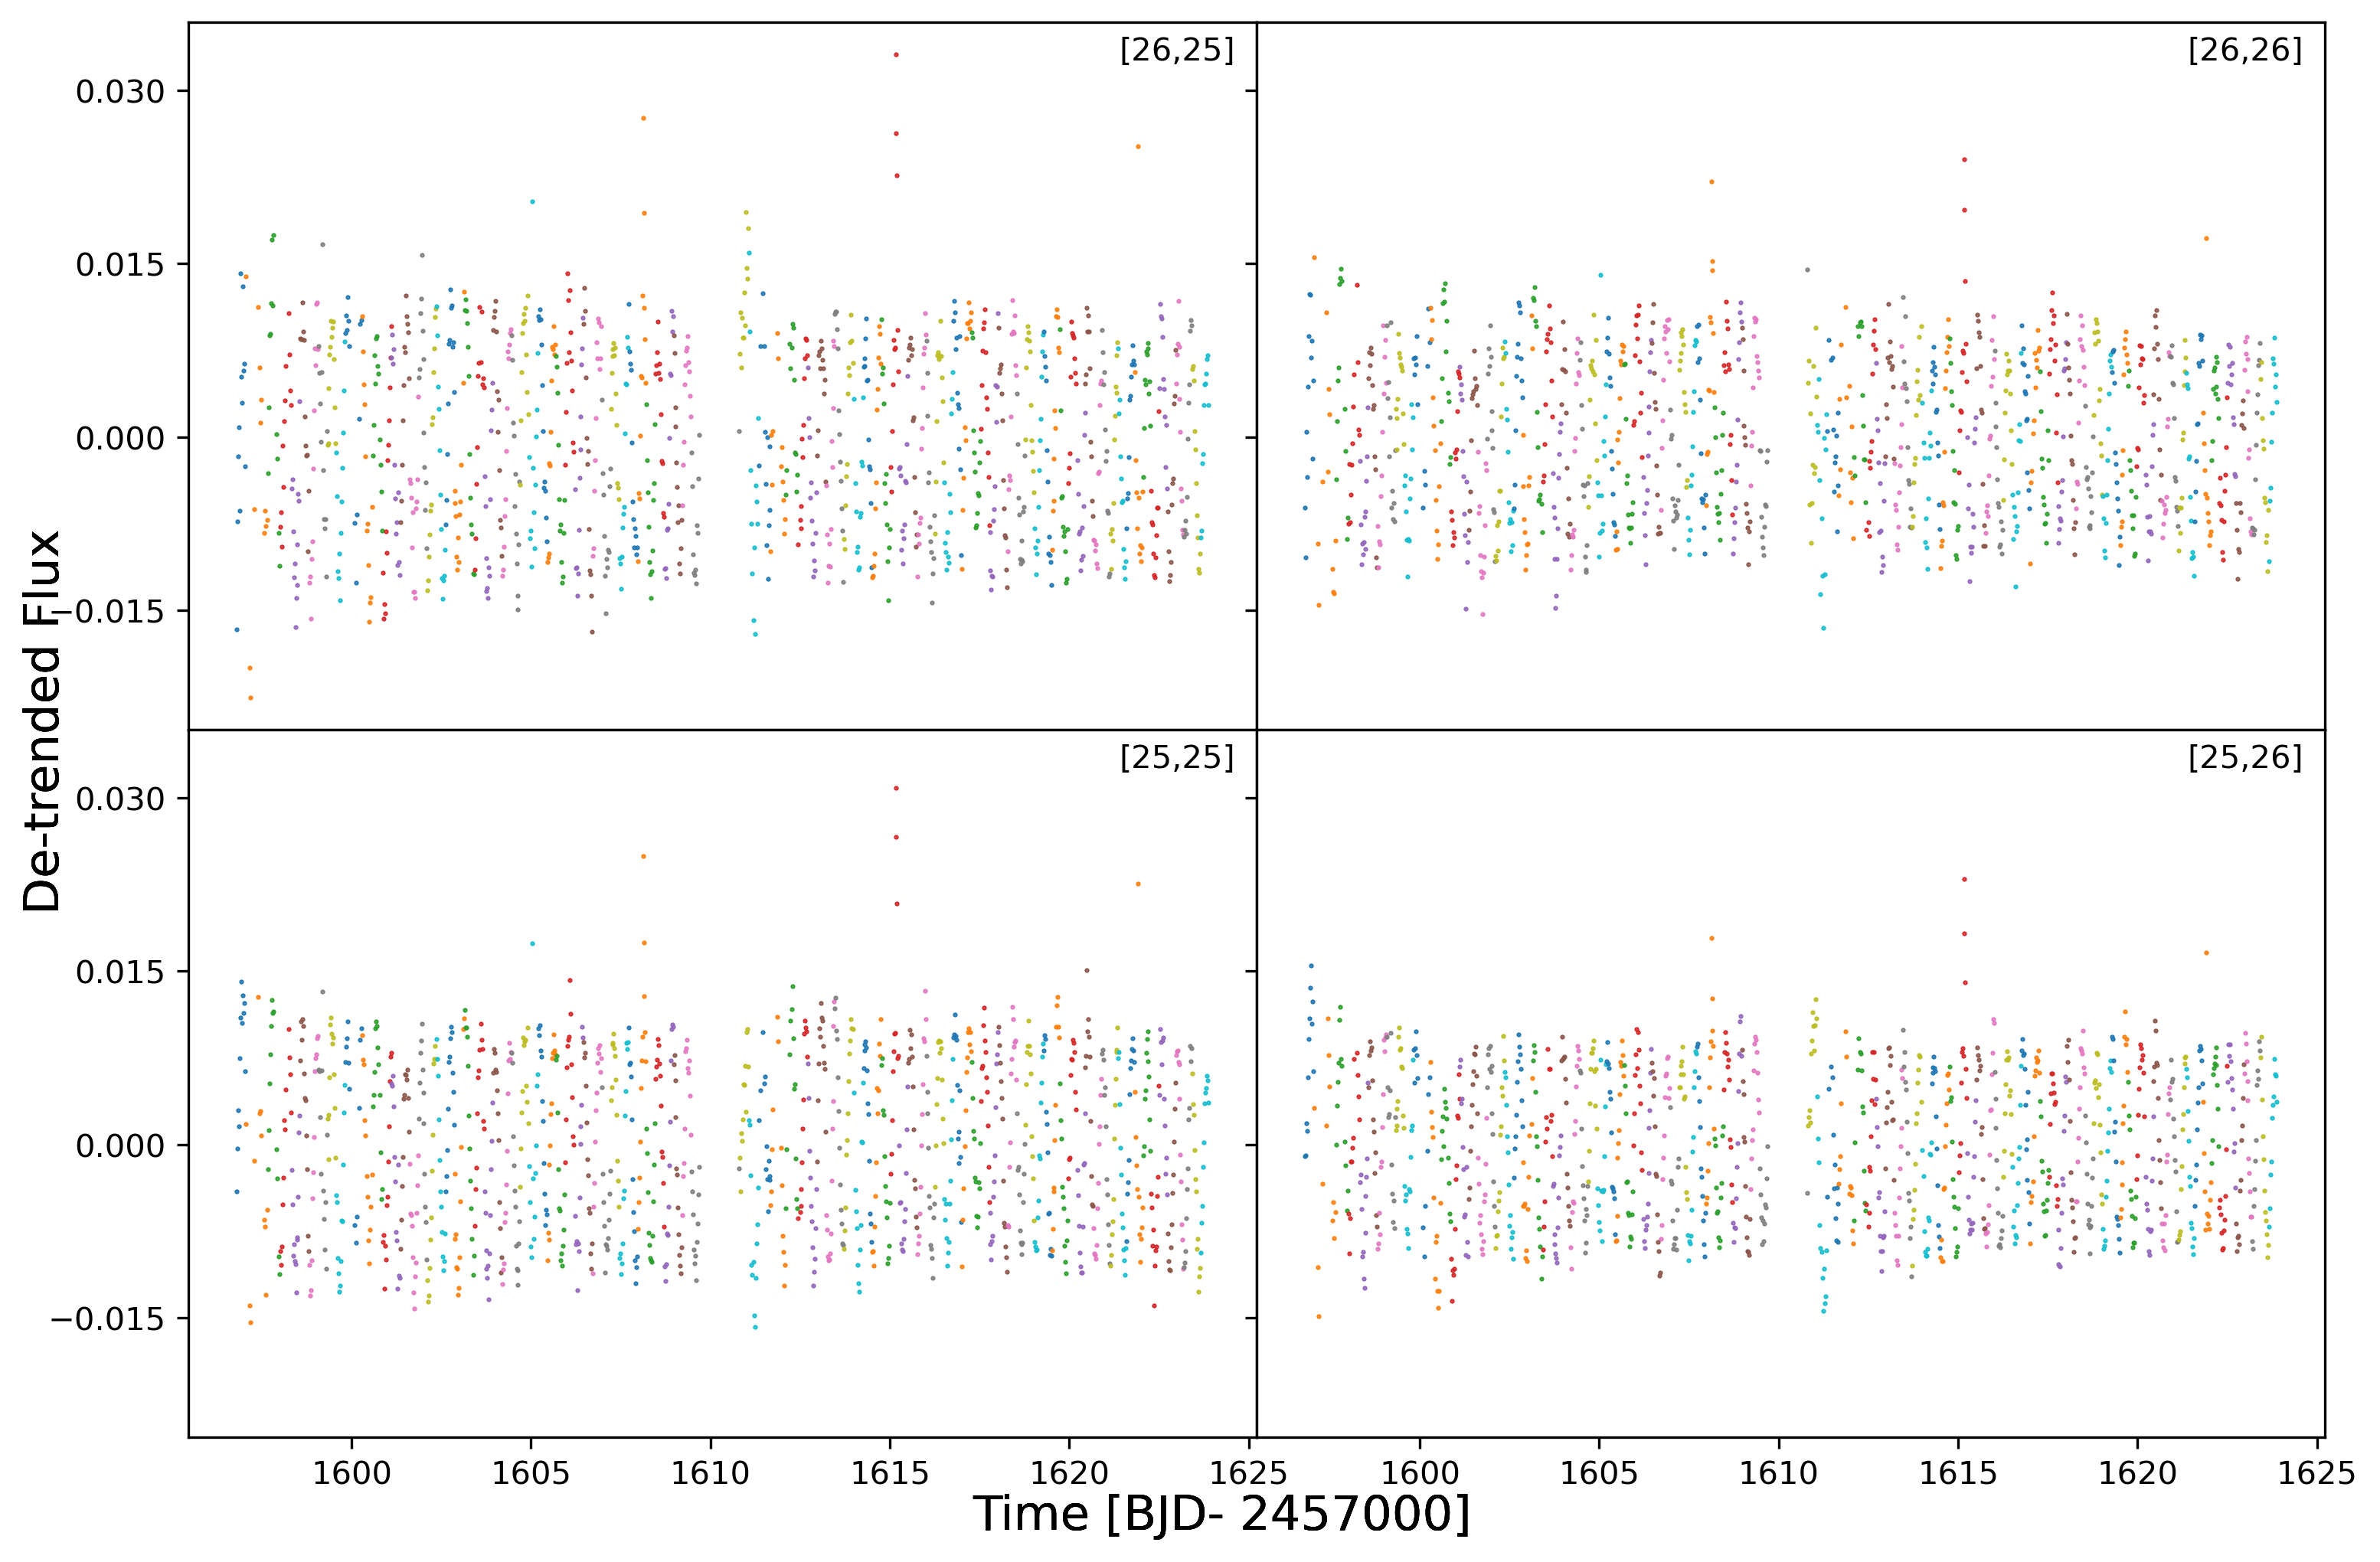

In [25]:
s.plot_pix_by_pix(data_type="cpm_subtracted_flux", split=True);

Let's compare the original flux to what CPM was able to capture.\
We'll sum up the pixel light curves using the `get_aperture_lc()` method.\
For summing pixel light curves, the current default setting is to weight them by their median values (Thanks Ben!). If you don't want any weighting, you can simply specify `weighting=None`.

Summing over 2 x 2 pixel lightcurves. Weighting=None
Summing over 2 x 2 pixel lightcurves. Weighting=None


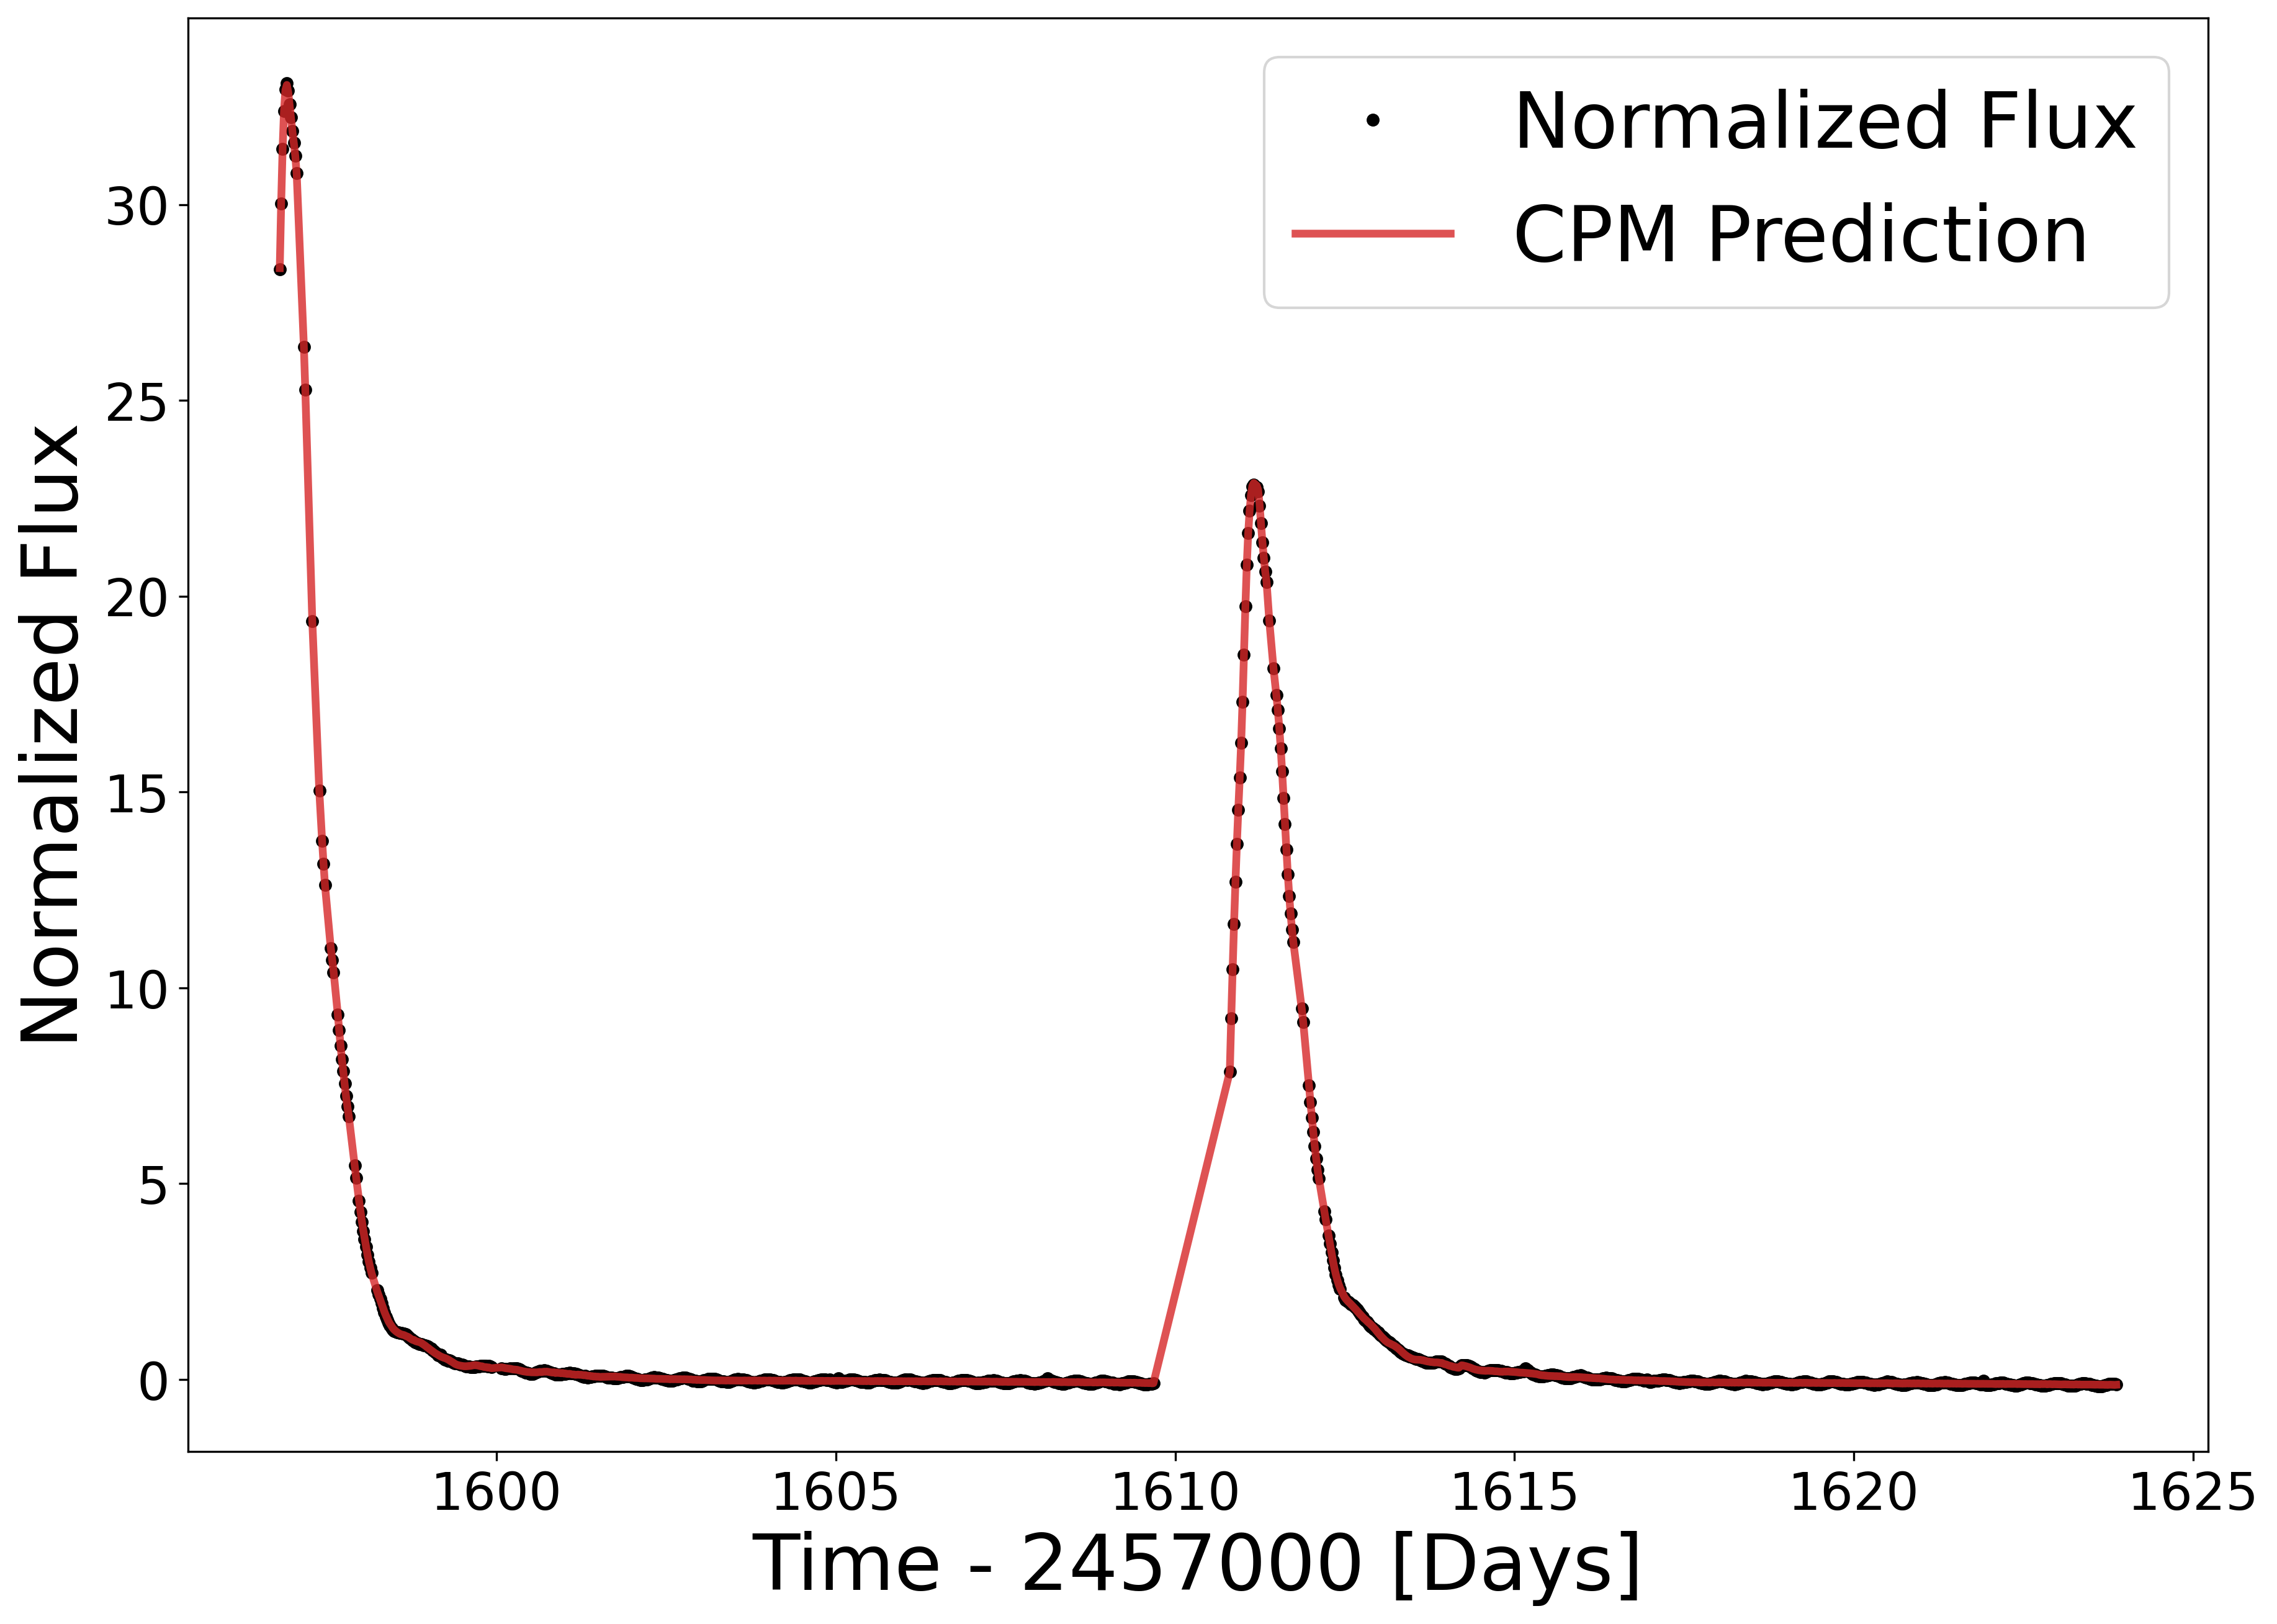

In [34]:
aperture_normalized_flux = s.get_aperture_lc(data_type="normalized_flux")
aperture_cpm_prediction = s.get_aperture_lc(data_type="cpm_prediction", weighting=None)
plt.plot(s.time, aperture_normalized_flux, ".", c="k", ms=8, label="Normalized Flux")
plt.plot(s.time, aperture_cpm_prediction, "-", lw=3, c="C3", alpha=0.8, label="CPM Prediction")
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("Normalized Flux", fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(fontsize=30)

Let's also sum up the CPM-subtracted fluxes.

Summing over 2 x 2 pixel lightcurves. Weighting=None


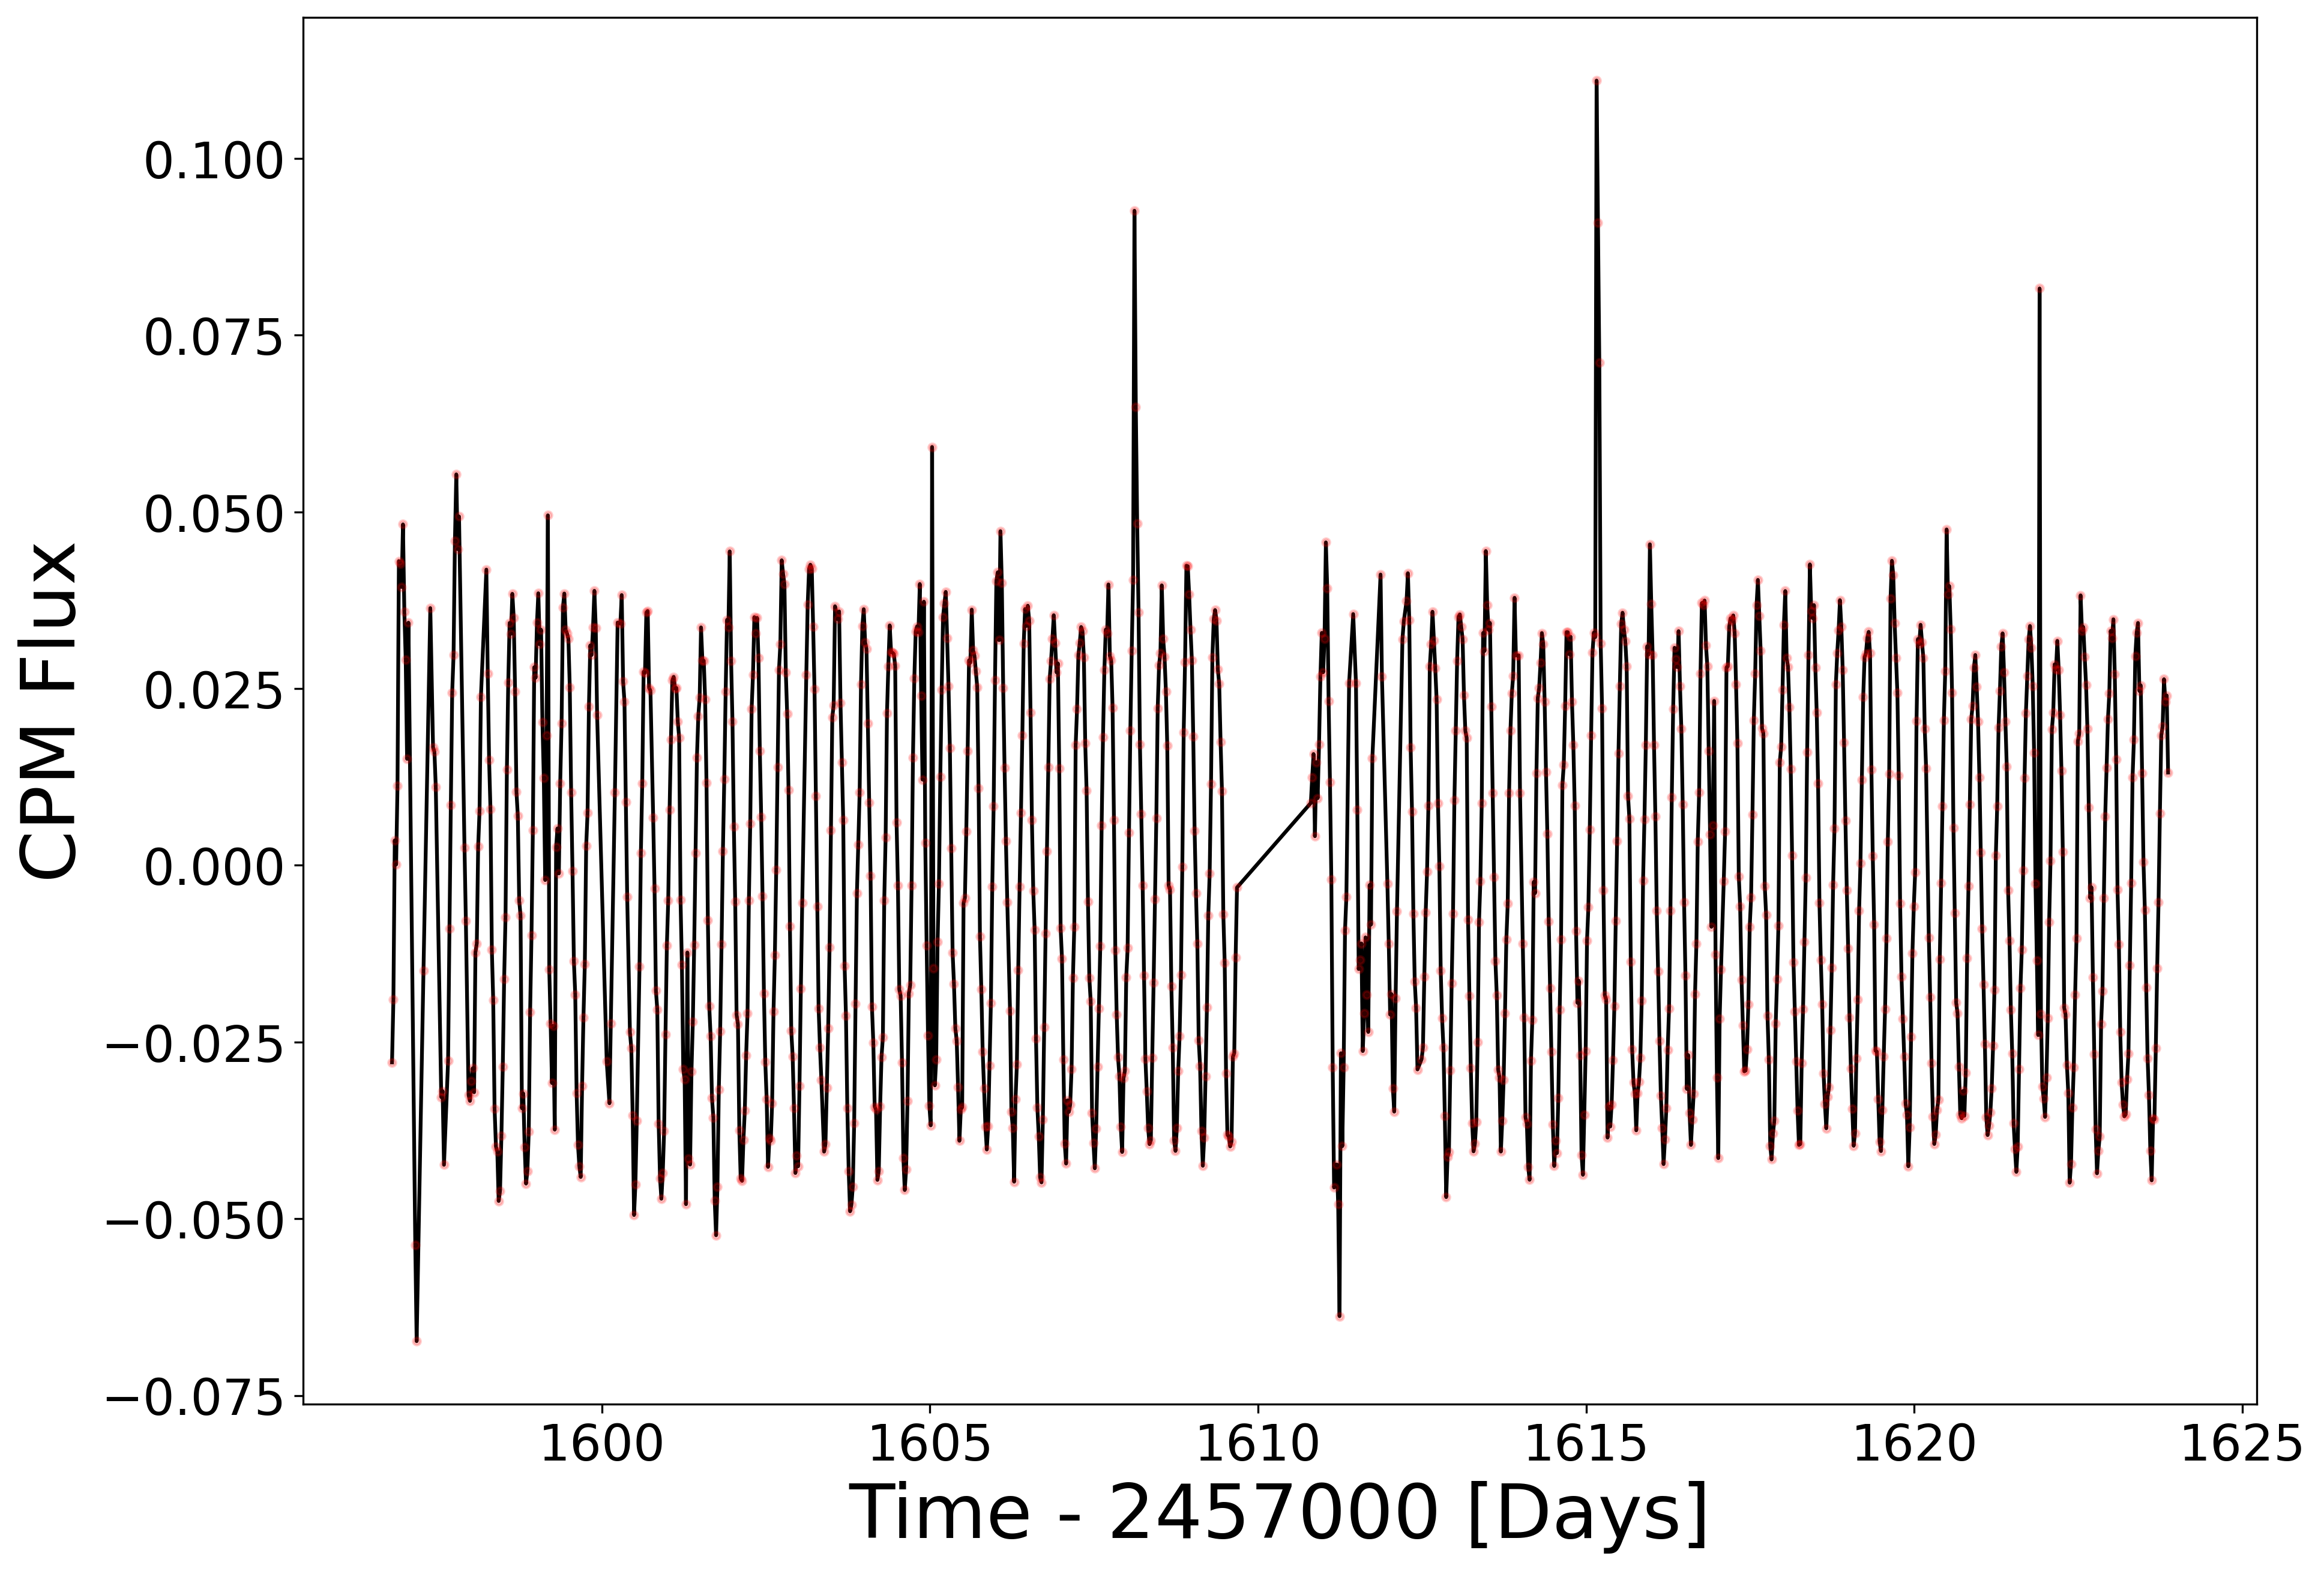

In [36]:
apt_detrended_flux = s.get_aperture_lc(data_type="cpm_subtracted_flux")
plt.plot(s.time, apt_detrended_flux, "k-")
plt.plot(s.time, aperture_normalized_flux-aperture_cpm_prediction, "r.", alpha=0.2)  # Gives you the same light curve as the above line
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)

Since it seems like there's some oscillation in that light curve, we can check it out using the `lightkurve` package ([Lightkurve Collaboration 2018](https://ui.adsabs.harvard.edu/abs/2018ascl.soft12013L/abstract))!

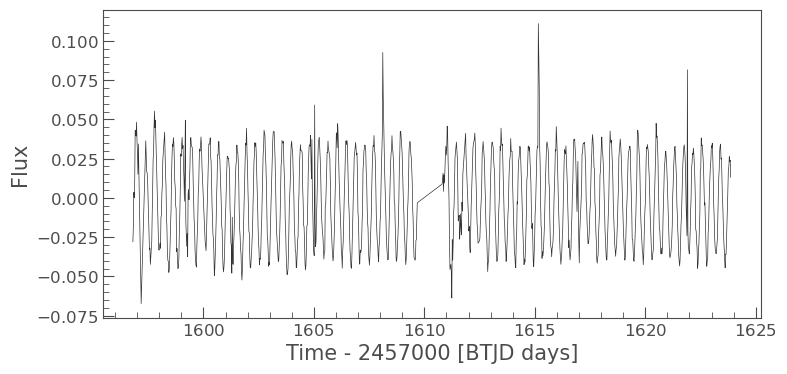

In [38]:
import lightkurve as lk
lc = lk.TessLightCurve(time=s.time, flux=apt_detrended_flux)
lc.plot();

Max Power Period: 0.41317248041827637 d


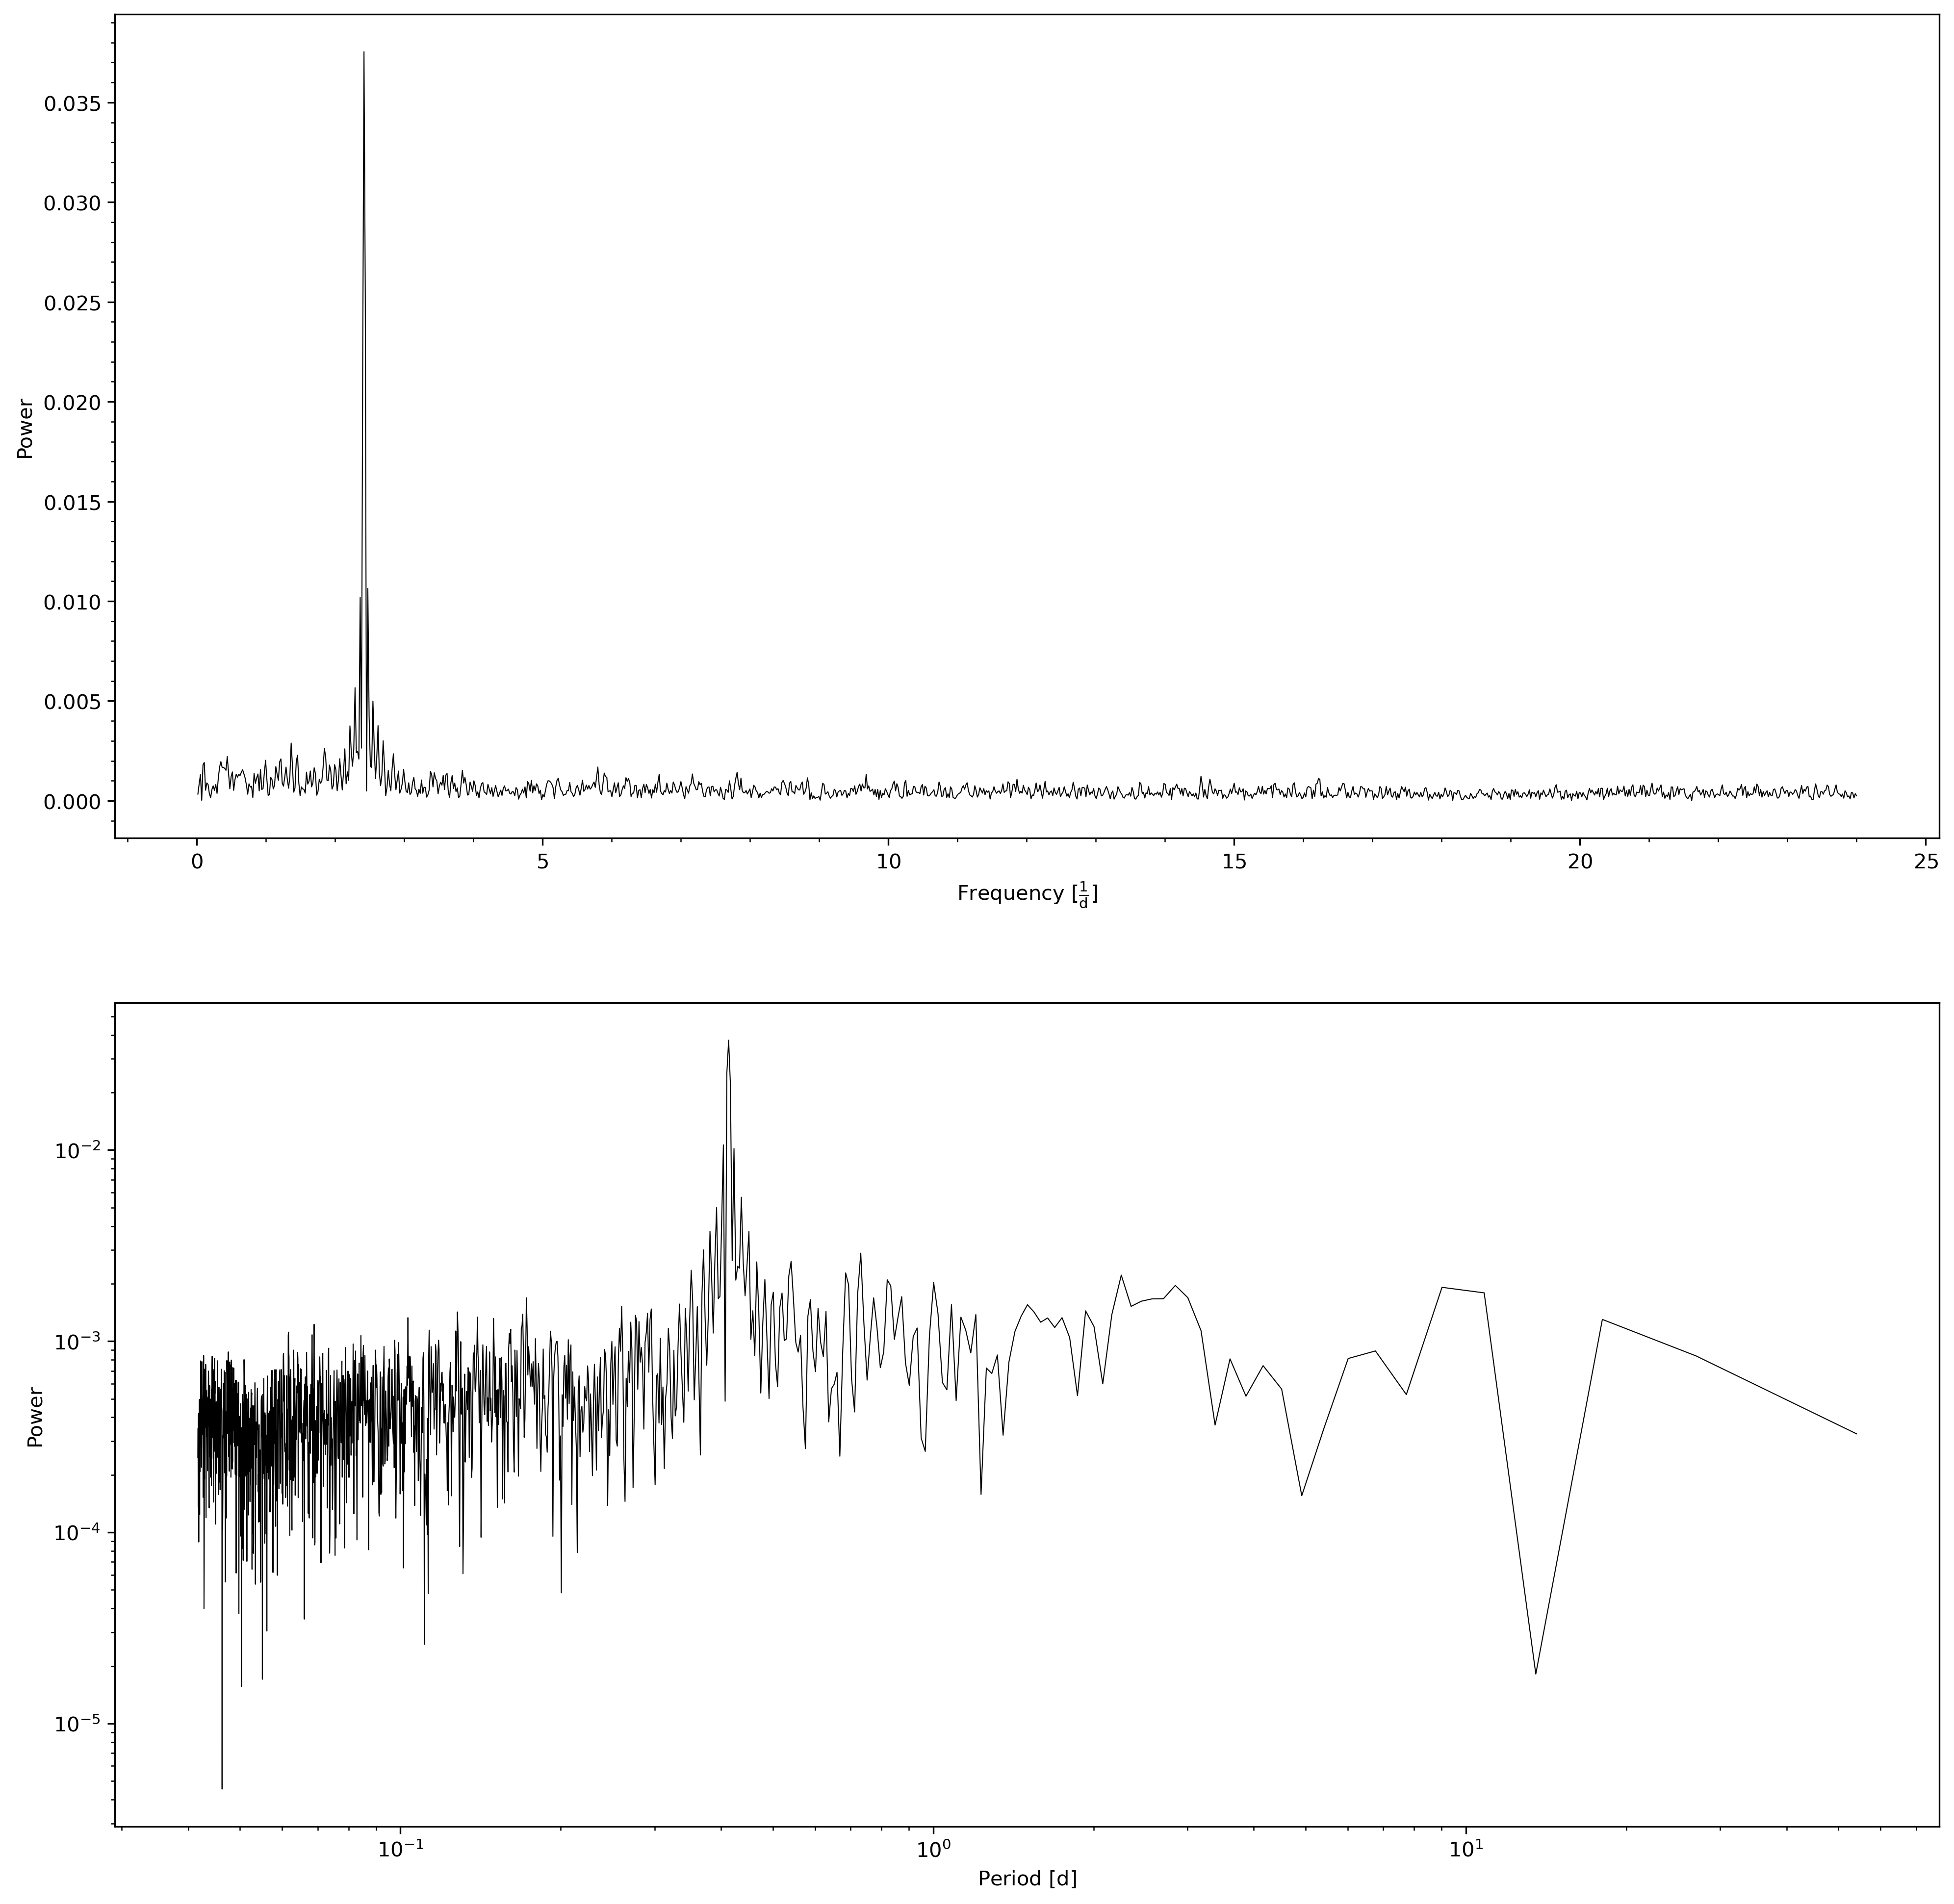

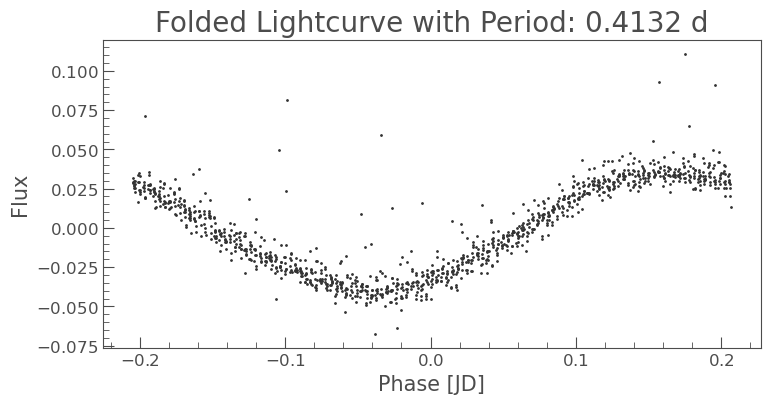

In [40]:
pg = lc.to_periodogram(oversample_factor=2)
fig, axs = plt.subplots(2, 1, figsize=(16, 16))
pg.plot(ax=axs[0], c='k')
pg.plot(ax=axs[1], c='k', view='period', scale="log")
# fig.suptitle("Periodogram", fontsize=20, y=0.95)
period = pg.period_at_max_power
print(f"Max Power Period: {period}")
lc.fold(period.value).scatter()
plt.title(f"Folded Lightcurve with Period: {period:.4f}", fontsize=20);

## **Example 2 (ASASSN-18tb)**
For the second example we'll attempt to create a supernova light curve for ASASSN-18tb ([Vallely et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.487.2372V/abstract)).\
We'll start off with downloading the data again. This particular set of coordinates was in the TESS Cycle 1 Continuous Viewing Zone (CVZ) and hence has data from Sectors 1 through 13. Since downloading data takes time, we'll restrict ourselves to just Sectors 1 and 2.\

In [ ]:
from astropy.coordinates import SkyCoord
# path_to_FFIs = check_before_download(coordinates=SkyCoord(64.525833, -63.615669, unit="deg"), sector=1, size=50)
search_result = lk.search_tesscut(target=SkyCoord(64.525833, -63.615669, unit="deg"), sector=[1, 2])
search_result

In [ ]:
tpf_collection = search_result.download_all(cutout_size=50)
tpf_collection

In [ ]:
s1 = tess_cpm.Source(tpf_collection[0].path, remove_bad=True)
_ = s1.plot_cutout()

In [ ]:
s1.set_aperture(rowlims=[24, 26], collims=[24, 26])
_ = s1.plot_cutout(rowlims=[20, 30], collims=[20, 30], show_aperture=True)

In [ ]:
_ = s1.plot_pix_by_pix()  # This method plots the raw flux values
_ = s1.plot_pix_by_pix(data_type="normalized_flux")

In contrast to Example 1, when we specify our model for this source we'll also add a polynomical model component.\
A polynomial model is needed in sources that have 'long-term astrophysical trends' (i.e., supernova).\
While in theory CPM should only capture systematic effects, in practice CPM is flexible enough to capture these long-term trends. To prevent CPM from modeling the signal, we add this polynomical component using the `add_poly_model()` to capture long-term trends.\
The `scale` keyword argument scales the input (a larger value allows more flexibility for a polynomial of a given degree). The `num_terms` keyword argument specifies the degree of the polynomial. As the first term of the polynomial is a constant, the highest degree is `num_terms - 1`. 

In [ ]:
s1.add_cpm_model(exclusion_size=5, n=64, predictor_method="similar_brightness")
s1.add_poly_model(scale=2, num_terms=4)

In [ ]:
s1.set_regs([0.01, 0.1])  # The first term is the CPM regularization while the second term is the polynomial regularization value.
s1.holdout_fit_predict(k=50);  # When fitting with a polynomial component, we've found it's better to increase the number of sections.

Let's see what the polynomial model captured.\
Since our hope was that the polynomial model captured the long-term astrophysical signal, we **do not** want to subtract that from our original light curve.\
Let's also see what the CPM-subtracted flux looks like (the polynmomial model is not subtracted).

In [ ]:
s1.plot_pix_by_pix(data_type="poly_model_prediction", split=True);
s1.plot_pix_by_pix(data_type="cpm_subtracted_flux");

In [ ]:
s1_aperture_normalized_flux = s1.get_aperture_lc(data_type="normalized_flux")
s1_aperture_cpm_prediction = s1.get_aperture_lc(data_type="cpm_prediction")
s1_aperture_poly_prediction = s1.get_aperture_lc(data_type="poly_model_prediction")
plt.plot(s1.time, s1_aperture_normalized_flux, ".", c="k", ms=8, label="Normalized Flux")
plt.plot(s1.time, s1_aperture_cpm_prediction, "-", lw=3, c="C3", alpha=0.8, label="CPM Prediction")
plt.plot(s1.time, s1_aperture_poly_prediction, "-", lw=3, c="C0", alpha=0.8, label="Polynomial Prediction")

plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("Normalized Flux", fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(fontsize=30)

In [ ]:
s1_aperture_detrended_flux = s1.get_aperture_lc(data_type="cpm_subtracted_flux")
plt.plot(s1.time, s1_aperture_detrended_flux, "k-")
# plt.plot(s1.time, s1_aperture_normalized_flux-aperture_cpm_prediction, "r.", alpha=0.2)  # Gives you the same light curve as the above line
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)

Let's quickly do the same for the Sector 2 data.

In [ ]:
s2 = tess_cpm.Source(tpf_collection[1].path)
_ = s2.plot_cutout()
s2.set_aperture(rowlims=[24, 26], collims=[24, 26])
_ = s2.plot_cutout(rowlims=[20, 30], collims=[20, 30], show_aperture=True)

In [ ]:
s2.add_cpm_model(exclusion_size=5, n=64, predictor_method="similar_brightness")
s2.add_poly_model(scale=2, num_terms=4)
s2.set_regs([0.01, 0.1])  
s2.holdout_fit_predict(k=50);

In [ ]:
s2.plot_pix_by_pix(data_type="poly_model_prediction", split=True);
s2.plot_pix_by_pix(data_type="cpm_subtracted_flux");

In [ ]:
s2_aperture_normalized_flux = s2.get_aperture_lc(data_type="normalized_flux")
s2_aperture_cpm_prediction = s2.get_aperture_lc(data_type="cpm_prediction")
s2_aperture_poly_prediction = s2.get_aperture_lc(data_type="poly_model_prediction")
plt.plot(s2.time, s2_aperture_normalized_flux, ".", c="k", ms=8, label="Normalized Flux")
plt.plot(s2.time, s2_aperture_cpm_prediction, "-", lw=3, c="C3", alpha=0.8, label="CPM Prediction")
plt.plot(s2.time, s2_aperture_poly_prediction, "-", lw=3, c="C0", alpha=0.8, label="Polynomial Prediction")

plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("Normalized Flux", fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(fontsize=30)

In [ ]:
s2_aperture_detrended_flux = s2.get_aperture_lc(data_type="cpm_subtracted_flux")
plt.plot(s2.time, s2_aperture_detrended_flux, "k-")
# plt.plot(s2.time, s2_aperture_normalized_flux-aperture_cpm_prediction, "r.", alpha=0.2)  # Gives you the same light curve as the above line
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)

## **Stitching light curves**
Since we have light curves from two different sectors, let's stitch them together.\
The code I wrote to stitch them together is extremely hacky and definitely needs to be replaced with something reasonable!\
The flux should also be calibrated between multiple sectors before stitching.

In [ ]:
diff, pars, st_time, st_lc = tess_cpm.utils.stitch_sectors(s1.time, s2.time, s1_aperture_detrended_flux, s2_aperture_detrended_flux)
plt.figure(figsize=(16, 10))
plt.plot(s1.time, s1_aperture_detrended_flux, c="k", label="Sector 1")
plt.plot(s2.time, s2_aperture_detrended_flux + diff, c="C3", label="Sector 2")


plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(fontsize=30)